In [1]:
# ================================================================================
# NFL BIG DATA BOWL 2026 - FULLY WORKING COMPREHENSIVE SOLUTION
# Complete Implementation with All Features & Visualizations
# ================================================================================

import os
import glob
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm.auto import tqdm

# Models
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

# Preprocessing & Analysis
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error

import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

warnings.filterwarnings('ignore')

# Plotting settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100

print("="*90)
print(" "*10 + "NFL BIG DATA BOWL 2026 - FULLY WORKING SOLUTION")
print(" "*15 + "Complete Implementation with All Features")
print("="*90)

# ================================================================================
# PART 1: DATA LOADING
# ================================================================================
print("\n📊 PART 1: DATA LOADING")
print("="*90)

DATA_DIR = "/Users/ryanparks/Downloads/compsci_ai/big_data_bowl/nfl-big-data-bowl-2026-prediction/"

# Load data
print("Loading training data...")
input_files = sorted(glob.glob(os.path.join(DATA_DIR, "train/input_2023_w*.csv")))
output_files = sorted(glob.glob(os.path.join(DATA_DIR, "train/output_2023_w*.csv")))

df_in = pd.concat((pd.read_csv(p) for p in tqdm(input_files, desc="Input files")), ignore_index=True)
df_out = pd.concat((pd.read_csv(p) for p in tqdm(output_files, desc="Output files")), ignore_index=True)

print("Loading test data...")
test_in = pd.read_csv(os.path.join(DATA_DIR, "test_input.csv"))
test_template = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))
supp_path = DATA_DIR + "supplementary_data.csv"
supplementary = pd.read_csv(supp_path)

# Heuristic: contains 'zone' (case-insensitive) -> 'zone'; else 'man'; NaN -> 'unknown'
cov_raw = supplementary["team_coverage_type"]
cov_str = cov_raw.astype("string").str.lower()
coverage_man_zone = pd.Series("unknown", index=supplementary.index, dtype="string")
coverage_man_zone = coverage_man_zone.mask(cov_str.notna() & cov_str.str.contains("zone", na=False), "zone")
coverage_man_zone = coverage_man_zone.mask(cov_str.notna() & ~cov_str.str.contains("zone", na=False), "man")

supplementary["coverage_man_zone"] = coverage_man_zone
supplementary["coverage_is_man"] = (supplementary["coverage_man_zone"] == "man").astype("int8")
supplementary["coverage_is_zone"] = (supplementary["coverage_man_zone"] == "zone").astype("int8")
supplementary["coverage_is_unknown"] = (supplementary["coverage_man_zone"] == "unknown").astype("int8")

# Keep one row per (game_id, play_id) for a clean many:one merge
key_cols = ["game_id", "play_id"]
for k in key_cols:
    if k not in supplementary.columns:
        raise KeyError(f"'{k}' column is required in supplementary_data.csv for merging.")
supp_play = (supplementary
                .drop_duplicates(subset=key_cols, keep="first")
                [key_cols + ["coverage_man_zone", "coverage_is_man", "coverage_is_zone", "coverage_is_unknown"]]
                .reset_index(drop=True))

# Merge into train_input / train_output (many frames to one play row)
df_in = df_in.merge(
    supp_play, on=key_cols, how="left", validate="m:1"
)
df_out = df_out.merge(
    supp_play, on=key_cols, how="left", validate="m:1"
)

test_in = test_in.merge(
    supp_play, on=key_cols, how="left", validate="m:1"
)
test_template = test_template.merge(
    supp_play, on=key_cols, how="left", validate="m:1"
)
dist = df_in["coverage_man_zone"].value_counts(dropna=False)
print("[coverage] distribution in train_input:\n", dist.to_string())
print(f"\n✓ Data Shapes:")
print(f"  • Training inputs: {df_in.shape}")
print(f"  • Training outputs: {df_out.shape}")
print(f"  • Test inputs: {test_in.shape}")
print(f"  • Test template: {test_template.shape}")

          NFL BIG DATA BOWL 2026 - FULLY WORKING SOLUTION
               Complete Implementation with All Features

📊 PART 1: DATA LOADING
Loading training data...


Input files:   0%|          | 0/18 [00:00<?, ?it/s]

Output files:   0%|          | 0/18 [00:00<?, ?it/s]

Loading test data...
[coverage] distribution in train_input:
 coverage_man_zone
zone       3587126
man        1292781
unknown        672

✓ Data Shapes:
  • Training inputs: (4880579, 27)
  • Training outputs: (562936, 10)
  • Test inputs: (49753, 27)
  • Test template: (5837, 8)


In [2]:
import joblib
# joblib.dump({
#     'preds_matlab': merged_play_3
# }, 'preds_matlab.joblib')

# print("Saved preds to preds_matlab.joblib")
#merged_play_3
efficient_routes = joblib.load('preds_matlab.joblib')

In [13]:
efficient_routes = efficient_routes['preds_matlab']

In [6]:
supplementary.columns

Index(['game_id', 'season', 'week', 'game_date', 'game_time_eastern',
       'home_team_abbr', 'visitor_team_abbr', 'play_id', 'play_description',
       'quarter', 'game_clock', 'down', 'yards_to_go', 'possession_team',
       'defensive_team', 'yardline_side', 'yardline_number',
       'pre_snap_home_score', 'pre_snap_visitor_score',
       'play_nullified_by_penalty', 'pass_result', 'pass_length',
       'offense_formation', 'receiver_alignment', 'route_of_targeted_receiver',
       'play_action', 'dropback_type', 'dropback_distance',
       'pass_location_type', 'defenders_in_the_box', 'team_coverage_man_zone',
       'team_coverage_type', 'penalty_yards', 'pre_penalty_yards_gained',
       'yards_gained', 'expected_points', 'expected_points_added',
       'pre_snap_home_team_win_probability',
       'pre_snap_visitor_team_win_probability',
       'home_team_win_probability_added', 'visitor_team_win_probility_added',
       'coverage_man_zone', 'coverage_is_man', 'coverage_is_zone'

In [10]:
df_in['player_role']

0          Defensive Coverage
1          Defensive Coverage
2          Defensive Coverage
3          Defensive Coverage
4          Defensive Coverage
                  ...        
4880574     Targeted Receiver
4880575     Targeted Receiver
4880576     Targeted Receiver
4880577     Targeted Receiver
4880578     Targeted Receiver
Name: player_role, Length: 4880579, dtype: object

In [14]:
efficient_routes

t          x          y        se  nfl_id     game_id  play_id
0       0.0  56.209998  17.257645  0.000600   46137  2023090700      101
1       0.1  56.582122  16.811913  0.006928   46137  2023090700      101
2       0.2  56.918600  16.375271  0.027173   46137  2023090700      101
3       0.3  57.278729  15.879229  0.060327   46137  2023090700      101
4       0.4  57.622742  15.381874  0.114246   46137  2023090700      101
...     ...        ...        ...       ...     ...         ...      ...
562931  1.3  44.382889  13.368975  0.008390   52647  2024010713     4018
562932  1.4  44.257340  13.517289  0.002984   52647  2024010713     4018
562933  1.5  44.153016  13.618967  0.000848   52647  2024010713     4018
562934  1.6  44.040063  13.712367  0.000550   52647  2024010713     4018
562935  1.7  43.960000  13.770000  0.000000   52647  2024010713     4018

[562936 rows x 7 columns]

In [21]:
import numpy as np
import pandas as pd

# 1) Identify targeted receivers (unique per play)
tr_keys = (
    df_in.loc[df_in["player_role"].eq("Targeted Receiver"),
              ["game_id", "play_id", "nfl_id"]]
    .drop_duplicates()
)

# 2) Keep only efficient paths for those targeted receivers
efficient_tr = (
    efficient_routes
    .merge(tr_keys, on=["game_id", "play_id", "nfl_id"], how="inner")
)

# 3) Compute per-(game, play, player) RMSE using your formula
# rmse = sqrt(0.5 * mean(se))
rmse_by_play = (
    efficient_tr
    .groupby(["game_id", "play_id", "nfl_id"], as_index=False)["se"]
    .mean()
    .assign(rmse=lambda d: np.sqrt(0.5 * d["se"]))
    .drop(columns=["se"])
)

# 4) (Optional) Attach route/coverage info for interpretation
cols = [
    "game_id", "play_id",
    "route_of_targeted_receiver",
    "team_coverage_man_zone", "team_coverage_type",
    "pass_result", "pass_length", "pass_location_type", "expected_points_added"
]
rmse_with_meta = rmse_by_play.merge(
    supplementary[[c for c in cols if c in supplementary.columns]].drop_duplicates(["game_id","play_id"]),
    on=["game_id", "play_id"],
    how="left"
)

# 5) Lowest-RMSE examples overall (or use nlargest to get worst fits)
best_50 = rmse_with_meta.nsmallest(50, "rmse")
worst_50 = rmse_with_meta.nlargest(50, "rmse")


In [22]:
worst_50

game_id  play_id  nfl_id      rmse route_of_targeted_receiver  \
811    2023091100     3167   54475  2.218831                     CORNER   
12215  2023122408     3377   44896  0.941872                      CROSS   
8438   2023111910     3231   55884  0.896048                     CORNER   
10464  2023121006     1062   45052  0.875114                         GO   
3899   2023100808     4040   56042  0.839912                         GO   
10671  2023121010     1241   52423  0.706643                         GO   
5801   2023102903      580   54476  0.700049                         GO   
151    2023091002     1260   40026  0.687509                       POST   
4432   2023101505     3518   55133  0.677278                         GO   
6012   2023102907      759   39973  0.657221                         GO   
8596   2023112300     3887   54499  0.648313                       POST   
3003   2023100108     1584   47859  0.641365                       POST   
8436   2023111910     3146   54054  0.631462                         GO   
3404   2023100500     3697   47859  0.612924                         GO   
9773   2023120306     1480   43454  0.601064                         GO   
10352  2023121004     1364   44849  0.598219                       POST   
5107   2023102202     3858   42347  0.596571                         GO   
9897   2023120308     3974   53463  0.592527                     CORNER   
12233  2023122409      360   52451  0.588754                       POST   
9457   2023113000     4678   55884  0.584697                        OUT   
3018   2023100108     2805   53511  0.581550                       POST   
6131   2023102909     1087   53463  0.566146                      HITCH   
1386   2023091709     2854   53486  0.565314                        OUT   
6258   2023102911     3916   46243  0.560060                         GO   
7346   2023111203     2663   46116  0.556710                         GO   
11260  2023121703     3824   45052  0.553394                         GO   
1512   2023091711     4627   54967  0.539709                         GO   
2155   2023092407     1500   45185  0.535442                     CORNER   
8772   2023112400     4136   54475  0.523313                       POST   
5843   2023102903     3968   54476  0.520304                       POST   
9326   2023112610     1979   53456  0.517118                        OUT   
9678   2023120304     2334   52659  0.514907                      HITCH   
4156   2023101500     1949   55886  0.513588                         GO   
7463   2023111205     4137   55915  0.507255                         GO   
10410  2023121005       86   55904  0.503996                         GO   
2491   2023092500     2896   53439  0.496672                      CROSS   
7500   2023111206     2711   39973  0.496295                      CROSS   
10175  2023121001      481   44881  0.495759                         GO   
8546   2023112300       55   54499  0.493393                         GO   
10163  2023121000     3769   54473  0.489017                         GO   
3596   2023100803      157   52442  0.477675                         GO   
10435  2023121005     2288   54476  0.474526                         GO   
11692  2023122100     2100   55133  0.468113                         GO   
13399  2024010601      403   53518  0.464740                       POST   
11502  2023121710      374   53463  0.463360                         GO   
13462  2024010700     2516   54473  0.457646                         GO   
6786   2023110506     3838   52429  0.457473                         GO   
10030  2023120400     1803   46095  0.457352                         GO   
8480   2023111911     2457   55928  0.454807                         GO   
10003  2023120310     3976   46243  0.443583                         GO   

      team_coverage_man_zone team_coverage_type pass_result  pass_length  \
811            ZONE_COVERAGE       COVER_2_ZONE           C           14   
12215           MAN_COVERAGE    

In [20]:
rmse_with_meta

game_id  play_id  nfl_id      rmse route_of_targeted_receiver  \
0      2023090700      101   44930  0.349576                     CORNER   
1      2023090700      194   41325  0.007047                      ANGLE   
2      2023090700      219   53591  0.037979                      HITCH   
3      2023090700      361   38696  0.093074                      HITCH   
4      2023090700      436   53541  0.025739                      SLANT   
...           ...      ...     ...       ...                        ...   
14103  2024010713     3836   54613  0.006745                      SLANT   
14104  2024010713     3906   43454  0.084532                      HITCH   
14105  2024010713     3936   46192  0.060918                        OUT   
14106  2024010713     3995   43454  0.095116                     CORNER   
14107  2024010713     4018   52457  0.262055                        OUT   

      team_coverage_man_zone team_coverage_type pass_result  pass_length  \
0              ZONE_COVERAGE       COVER_2_ZONE           I           22   
1               MAN_COVERAGE        COVER_1_MAN           C            6   
2              ZONE_COVERAGE       COVER_4_ZONE           C            4   
3              ZONE_COVERAGE       COVER_4_ZONE           C            5   
4               MAN_COVERAGE        COVER_1_MAN           C            6   
...                      ...                ...         ...          ...   
14103          ZONE_COVERAGE       COVER_4_ZONE           C            7   
14104          ZONE_COVERAGE       COVER_4_ZONE           C            6   
14105           MAN_COVERAGE        COVER_2_MAN           C            5   
14106          ZONE_COVERAGE       COVER_2_ZONE           I           22   
14107           MAN_COVERAGE        COVER_2_MAN          IN           18   

      pass_location_type  
0             INSIDE_BOX  
1             INSIDE_BOX  
2             INSIDE_BOX  
3          OUTSIDE_RIGHT  
4             INSIDE_BOX  
...                  ...  
14103         INSIDE_BOX  
14104         INSIDE_BOX  
14105         INSIDE_BOX  
14106         INSIDE_BOX  
14107         INSIDE_BOX  

[14108 rows x 10 columns]

In [24]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

df = rmse_with_meta.copy()

# Keep only rows with the fields we need
use_cols = ["rmse", "expected_points_added", "pass_result", "route_of_targeted_receiver"]
df = df[use_cols].dropna()

# -------------------------
# 1) rmse vs expected_points_added (numeric-numeric)
# -------------------------
pearson_r, pearson_p = stats.pearsonr(df["rmse"], df["expected_points_added"])
spearman_r, spearman_p = stats.spearmanr(df["rmse"], df["expected_points_added"])

print("rmse vs EPA")
print(f"  Pearson  r={pearson_r:.4f}, p={pearson_p:.3g}")
print(f"  Spearman ρ={spearman_r:.4f}, p={spearman_p:.3g}")

# -------------------------
# 2) rmse vs pass_result (categorical)
#    - group stats
#    - Kruskal-Wallis (nonparam) and ANOVA effect size (eta^2)
# -------------------------
print("\nrmse by pass_result (counts/means)")
print(df.groupby("pass_result")["rmse"].agg(["count", "mean", "median", "std"]).sort_values("count", ascending=False))

groups = [g["rmse"].to_numpy() for _, g in df.groupby("pass_result") if len(g) > 0]
if len(groups) >= 2:
    kw = stats.kruskal(*groups)
    print(f"\nKruskal-Wallis rmse ~ pass_result: H={kw.statistic:.3f}, p={kw.pvalue:.3g}")

# ANOVA + eta^2 (works fine even if you also use KW for robustness)
m_pass = smf.ols("rmse ~ C(pass_result)", data=df).fit()
anova_pass = sm.stats.anova_lm(m_pass, typ=2)
eta2_pass = anova_pass.loc["C(pass_result)", "sum_sq"] / anova_pass["sum_sq"].sum()
print("\nANOVA rmse ~ pass_result")
print(anova_pass)
print(f"eta^2 (pass_result explains): {eta2_pass:.4f}")

# -------------------------
# 3) rmse vs route_of_targeted_receiver (many categories)
#    - collapse rare routes into 'Other'
#    - show top routes by count + mean rmse
#    - Kruskal/ANOVA + eta^2
# -------------------------
MIN_N = 30  # tweak (20/30/50) depending on sample size
route_counts = df["route_of_targeted_receiver"].value_counts()
keep_routes = route_counts[route_counts >= MIN_N].index

df["route_grp"] = np.where(df["route_of_targeted_receiver"].isin(keep_routes),
                           df["route_of_targeted_receiver"],
                           "Other")

print(f"\nUnique routes (raw): {df['route_of_targeted_receiver'].nunique()}")
print(f"Unique routes (grouped, MIN_N={MIN_N}): {df['route_grp'].nunique()}")

route_stats = (
    df.groupby("route_grp")["rmse"]
      .agg(["count", "mean", "median", "std"])
      .sort_values(["count", "mean"], ascending=[False, True])
)
print("\nrmse by route (grouped)")
print(route_stats.head(25))

route_groups = [g["rmse"].to_numpy() for _, g in df.groupby("route_grp") if len(g) > 0]
if len(route_groups) >= 2:
    kw_r = stats.kruskal(*route_groups)
    print(f"\nKruskal-Wallis rmse ~ route_grp: H={kw_r.statistic:.3f}, p={kw_r.pvalue:.3g}")

m_route = smf.ols("rmse ~ C(route_grp)", data=df).fit()
anova_route = sm.stats.anova_lm(m_route, typ=2)
eta2_route = anova_route.loc["C(route_grp)", "sum_sq"] / anova_route["sum_sq"].sum()
print("\nANOVA rmse ~ route_grp")
print(anova_route)
print(f"eta^2 (route_grp explains): {eta2_route:.4f}")

# -------------------------
# 4) Optional: "partial" relationship:
#    rmse ~ EPA + pass_result + route (grouped)
# -------------------------
m_full = smf.ols("rmse ~ expected_points_added + C(pass_result) + C(route_grp)", data=df).fit(cov_type="HC3")
print("\nFull model: rmse ~ EPA + pass_result + route_grp")
print(m_full.summary().tables[1])


rmse vs EPA
  Pearson  r=-0.0237, p=0.00483
  Spearman ρ=-0.0169, p=0.0452

rmse by pass_result (counts/means)
             count      mean    median       std
pass_result                                     
C             9736  0.032818  0.016113  0.050702
I             4032  0.064326  0.031031  0.087761
IN             337  0.075297  0.034821  0.105322

Kruskal-Wallis rmse ~ pass_result: H=806.711, p=6.68e-176

ANOVA rmse ~ pass_result
                   sum_sq       df           F         PR(>F)
C(pass_result)   3.194335      2.0  376.643158  4.417428e-160
Residual        59.799995  14102.0         NaN            NaN
eta^2 (pass_result explains): 0.0507

Unique routes (raw): 12
Unique routes (grouped, MIN_N=30): 12

rmse by route (grouped)
           count      mean    median       std
route_grp                                     
HITCH       2660  0.053862  0.033320  0.056698
OUT         2214  0.037654  0.023294  0.045566
FLAT        1983  0.014720  0.009861  0.017810
CROSS       1

In [25]:


# rmse_by_play: [game_id, play_id, nfl_id, rmse]
# df_out: actual tracking for the player_to_predict (post-throw frames)
# df_in: contains ball_land_x, ball_land_y, num_frames_output, player_role, pass_result maybe merged elsewhere

# targeted receiver keys + landing info (one row per play/receiver)
tr_land = (
    df_in.loc[df_in["player_role"].eq("Targeted Receiver"),
              ["game_id","play_id","nfl_id","ball_land_x","ball_land_y","num_frames_output"]]
    .drop_duplicates(["game_id","play_id","nfl_id"])
)

# start/end positions from df_out for that WR
start_end = (
    df_out.merge(tr_land[["game_id","play_id","nfl_id"]], on=["game_id","play_id","nfl_id"], how="inner")
         .sort_values(["game_id","play_id","nfl_id","frame_id"])
         .groupby(["game_id","play_id","nfl_id"], as_index=False)
         .agg(x0=("x","first"), y0=("y","first"),
              xT=("x","last"),  yT=("y","last"),
              f0=("frame_id","first"), fT=("frame_id","last"))
)

feat = (
    rmse_by_play.merge(tr_land, on=["game_id","play_id","nfl_id"], how="left")
               .merge(start_end, on=["game_id","play_id","nfl_id"], how="left")
)

# distances to landing point
feat["D0"] = np.hypot(feat["x0"] - feat["ball_land_x"], feat["y0"] - feat["ball_land_y"])
feat["D_end"] = np.hypot(feat["xT"] - feat["ball_land_x"], feat["yT"] - feat["ball_land_y"])
feat["T_sec"] = 0.1 * feat["num_frames_output"]   # adjust if your frame rate differs
feat["v_req"] = feat["D0"] / feat["T_sec"]

# Correlations that diagnose confounding
for col in ["D_end", "D0", "T_sec", "v_req"]:
    r, p = stats.spearmanr(feat["rmse"], feat[col], nan_policy="omit")
    print(f"Spearman rmse vs {col}: ρ={r:.4f}, p={p:.3g}")


Spearman rmse vs D_end: ρ=0.1102, p=2.46e-39
Spearman rmse vs D0: ρ=0.3495, p=0
Spearman rmse vs T_sec: ρ=0.6679, p=0
Spearman rmse vs v_req: ρ=0.0995, p=2.2e-32


In [31]:
meta_cols = ["game_id", "play_id", "pass_result", "route_of_targeted_receiver"]
meta = supplementary[meta_cols].drop_duplicates(["game_id", "play_id"])

feat2 = feat.merge(meta, on=["game_id", "play_id"], how="left")

catchable2 = feat2[feat2["D_end"] <= 2.0].copy()   # adjust threshold if you want


In [32]:
print(catchable2.groupby("pass_result")["rmse"].agg(["count","mean","median","std"]))
print(catchable2.groupby("route_of_targeted_receiver")["rmse"].agg(["count","mean","median","std"]).sort_values("count", ascending=False))


             count      mean    median       std
pass_result                                     
C             8008  0.032257  0.015715  0.045840
I             2484  0.055972  0.026510  0.078093
IN             152  0.086752  0.038968  0.113545
                            count      mean    median       std
route_of_targeted_receiver                                     
HITCH                        1954  0.050253  0.031342  0.052211
FLAT                         1676  0.013763  0.009751  0.014436
OUT                          1648  0.034897  0.022127  0.040212
CROSS                        1170  0.021996  0.010249  0.038820
GO                            992  0.097170  0.063246  0.103308
IN                            775  0.026677  0.017589  0.029454
SLANT                         772  0.012065  0.009731  0.009757
POST                          528  0.061428  0.029198  0.083898
ANGLE                         471  0.019235  0.011285  0.019882
CORNER                        350  0.083254  0.0537

In [33]:
eps = 1e-6
feat2["rmse_per_sec"] = feat2["rmse"] / (feat2["T_sec"] + eps)
feat2["rmse_per_yd"]  = feat2["rmse"] / (feat2["D0"] + eps)

catchable2 = feat2[feat2["D_end"] <= 2.0].copy()


In [34]:
print(catchable2.groupby("pass_result")["rmse_per_yd"].agg(["count","mean","median","std"]))
print(catchable2.groupby("route_of_targeted_receiver")["rmse_per_yd"].agg(["count","mean","median","std"]).sort_values("count", ascending=False))


             count      mean    median       std
pass_result                                     
C             8008  0.013288  0.003513  0.044631
I             2484  0.011705  0.004188  0.030086
IN             152  0.012321  0.006514  0.018200
                            count      mean    median       std
route_of_targeted_receiver                                     
HITCH                        1954  0.042367  0.020412  0.085704
FLAT                         1676  0.004258  0.002391  0.008331
OUT                          1648  0.006082  0.003985  0.008597
CROSS                        1170  0.003826  0.001835  0.011717
GO                            992  0.007089  0.004696  0.008844
IN                            775  0.006740  0.003224  0.018159
SLANT                         772  0.002892  0.002248  0.002399
POST                          528  0.005526  0.003768  0.005802
ANGLE                         471  0.019549  0.006482  0.040000
CORNER                        350  0.006479  0.0048

In [ ]:

d = feat2.dropna(subset=["rmse","D0","T_sec"]).copy()

y = np.log1p(d["rmse"].to_numpy())  # log helps heavy tail
X = np.column_stack([
    np.ones(len(d)),
    np.log1p(d["D0"].to_numpy()),
    np.log1p(d["T_sec"].to_numpy()),
])

beta = np.linalg.lstsq(X, y, rcond=None)[0]
d["rmse_resid"] = y - X @ beta  # higher = more deviation than expected for depth/time

# attach pass_result + route already in d if you merged meta into feat2
catchable_resid = d[d["D_end"] <= 2.0].copy()

print(catchable_resid.groupby("pass_result")["rmse_resid"].agg(["count","mean","median","std"]))
print(catchable_resid.groupby("route_of_targeted_receiver")["rmse_resid"].agg(["count","mean","median","std"]).sort_values("count", ascending=False))


             count      mean    median       std
pass_result                                     
C             8008 -0.003422 -0.005566  0.031038
I             2484  0.000402 -0.005960  0.048241
IN             152  0.012874 -0.001575  0.067358
                            count      mean    median       std
route_of_targeted_receiver                                     
HITCH                        1954  0.007891 -0.000336  0.040037
FLAT                         1676 -0.010178 -0.009555  0.016491
OUT                          1648 -0.007385 -0.010656  0.026934
CROSS                        1170 -0.000215  0.002171  0.027785
GO                            992 -0.009305 -0.027569  0.067347
IN                            775 -0.000405 -0.002508  0.023910
SLANT                         772  0.005106  0.005078  0.012931
POST                          528 -0.001986 -0.009479  0.047760
ANGLE                         471  0.007916  0.005550  0.021875
CORNER                        350 -0.010154 -0.0261

In [36]:

eps = 1e-6

# efficient_tr: your efficient paths for targeted receivers only
# columns: t, x, y, se, nfl_id, game_id, play_id

def path_length(g):
    dx = g["x"].to_numpy()[1:] - g["x"].to_numpy()[:-1]
    dy = g["y"].to_numpy()[1:] - g["y"].to_numpy()[:-1]
    return np.sqrt(dx*dx + dy*dy).sum()

L_eff = (
    efficient_tr.sort_values(["game_id","play_id","nfl_id","t"])
               .groupby(["game_id","play_id","nfl_id"])
               .apply(path_length)
               .reset_index(name="L_eff")
)

feat3 = feat2.merge(L_eff, on=["game_id","play_id","nfl_id"], how="left")
feat3["rmse_per_L"] = feat3["rmse"] / (feat3["L_eff"] + eps)

# quick sanity: pass_result should look MUCH closer across groups now
print(feat3[feat3["D_end"] <= 2.0].groupby("pass_result")["rmse_per_L"].agg(["count","mean","median","std"]))
print(feat3[feat3["D_end"] <= 2.0].groupby("route_of_targeted_receiver")["rmse_per_L"].agg(["count","mean","median","std"]).sort_values("count", ascending=False))


             count        mean    median           std
pass_result                                           
C             8008   90.678621  0.003343   4774.050554
I             2484  207.299131  0.004175  10331.251868
IN             152    0.158851  0.005986      1.819629
                            count        mean    median           std
route_of_targeted_receiver                                           
HITCH                        1954  635.138544  0.019454  15127.022829
FLAT                         1676    0.003618  0.002080      0.006660
OUT                          1648    0.005660  0.003806      0.007412
CROSS                        1170    0.003460  0.001814      0.006750
GO                            992    0.006534  0.004539      0.006709
IN                            775    0.006807  0.003546      0.015465
SLANT                         772    0.003183  0.002442      0.002801
POST                          528    0.005482  0.003831      0.005870
ANGLE                    

In [41]:
import numpy as np
import pandas as pd

# --- 1) Keys for targeted WRs and coverage defenders (per play) ---
wr_keys = (
    df_in.loc[df_in["player_role"].eq("Targeted Receiver"),
              ["game_id", "play_id", "nfl_id"]]
    .drop_duplicates()
)

def_keys = (
    df_in.loc[df_in["player_role"].eq("Defensive Coverage"),
              ["game_id", "play_id", "nfl_id"]]
    .drop_duplicates()
)

# --- 2) Post-throw frames for WR and defenders from df_out ---
wr_frames = (
    df_out.merge(wr_keys, on=["game_id","play_id","nfl_id"], how="inner")
          .rename(columns={"nfl_id":"wr_nfl_id", "x":"x_wr", "y":"y_wr"})
)

def_frames = (
    df_out.merge(def_keys, on=["game_id","play_id","nfl_id"], how="inner")
          .rename(columns={"nfl_id":"def_nfl_id", "x":"x_def", "y":"y_def"})
)

# --- 3) Pair each WR frame with all defenders in same play+frame ---
pairs = wr_frames.merge(
    def_frames,
    on=["game_id","play_id","frame_id"],
    how="inner",
    suffixes=("", "_def")
)

pairs["dist"] = np.hypot(pairs["x_wr"] - pairs["x_def"], pairs["y_wr"] - pairs["y_def"])

# --- 4) Separation per frame = nearest defender distance ---
sep_frame = (
    pairs.groupby(["game_id","play_id","wr_nfl_id","frame_id"], as_index=False)["dist"]
         .min()
         .rename(columns={"dist":"sep"})
)

# --- 5) Start/end separation + gain per play ---
sep_sorted = sep_frame.sort_values(["game_id","play_id","wr_nfl_id","frame_id"])

sep_start = (
    sep_sorted.groupby(["game_id","play_id","wr_nfl_id"], as_index=False)
              .first()
              .rename(columns={"sep":"sep_start"})
)

sep_end = (
    sep_sorted.groupby(["game_id","play_id","wr_nfl_id"], as_index=False)
              .last()
              .rename(columns={"sep":"sep_end"})
)

sep_play = sep_start.merge(sep_end, on=["game_id","play_id","wr_nfl_id"], how="inner")
sep_play["sep_gain"] = sep_play["sep_end"] - sep_play["sep_start"]

# --- 6) Merge back to your play-level table (feat3 / feat2 / rmse table) ---
feat_sep = feat3.merge(
    sep_play.rename(columns={"wr_nfl_id":"nfl_id"}),
    on=["game_id","play_id","nfl_id"],
    how="left"
)


In [43]:

feat3 = feat3.copy()
feat3["rmse_resid"] = np.nan  # create column

mask = feat3[["rmse", "D0", "T_sec"]].notna().all(axis=1)

y = np.log1p(feat3.loc[mask, "rmse"].to_numpy())
X = np.column_stack([
    np.ones(mask.sum()),
    np.log1p(feat3.loc[mask, "D0"].to_numpy()),
    np.log1p(feat3.loc[mask, "T_sec"].to_numpy()),
])

beta = np.linalg.lstsq(X, y, rcond=None)[0]
feat3.loc[mask, "rmse_resid"] = y - (X @ beta)


In [44]:
feat_sep = feat3.merge(
    sep_play.rename(columns={"wr_nfl_id":"nfl_id"}),
    on=["game_id","play_id","nfl_id"],
    how="left"
)


In [ ]:

d = feat_sep[(feat_sep["D_end"] <= 2.0) & feat_sep["sep_gain"].notna()].copy()



In [45]:
d = feat_sep[(feat_sep["D_end"] <= 2.0) & feat_sep["sep_gain"].notna()].copy()

for x in ["rmse_per_L", "rmse_resid", "rmse_per_yd"]:
    rho, p = stats.spearmanr(d[x], d["sep_gain"], nan_policy="omit")
    print(f"{x} vs sep_gain: ρ={rho:.4f}, p={p:.3g}")


rmse_per_L vs sep_gain: ρ=-0.1393, p=2.85e-43
rmse_resid vs sep_gain: ρ=-0.0026, p=0.796
rmse_per_yd vs sep_gain: ρ=-0.1540, p=1.21e-52


In [47]:
d = feat_sep[(feat_sep["D_end"] <= 2.0) & feat_sep["sep_gain"].notna()].copy()

def route_rho(g):
    rho, p = stats.spearmanr(g["rmse_per_L"], g["sep_gain"], nan_policy="omit")
    return pd.Series({"n": len(g), "rho": rho, "p": p})

route_corrs = (
    d.groupby("route_of_targeted_receiver")
     .apply(route_rho)
     .sort_values("rho")
)

print(route_corrs)


                                 n       rho             p
route_of_targeted_receiver                                
ANGLE                        331.0 -0.269363  6.547324e-07
FLAT                        1231.0 -0.173931  8.090663e-10
SLANT                        761.0 -0.166951  3.647502e-06
CROSS                       1021.0 -0.164014  1.363855e-07
POST                         528.0 -0.133940  2.040115e-03
HITCH                       1924.0 -0.120504  1.147758e-07
OUT                         1592.0 -0.106002  2.254159e-05
SCREEN                       156.0 -0.096803  2.292991e-01
IN                           770.0 -0.067209  6.231533e-02
GO                           990.0 -0.067161  3.461020e-02
CORNER                       349.0 -0.044205  4.103574e-01
WHEEL                         62.0  0.318980  1.150673e-02


In [48]:

d["rmse_w"] = d["rmse_per_L"] - d.groupby("route_of_targeted_receiver")["rmse_per_L"].transform("mean")
d["sep_w"]  = d["sep_gain"]   - d.groupby("route_of_targeted_receiver")["sep_gain"].transform("mean")

rho, p = stats.spearmanr(d["rmse_w"], d["sep_w"], nan_policy="omit")
print(f"Within-route rmse_per_L vs sep_gain: ρ={rho:.4f}, p={p:.3g}")


Within-route rmse_per_L vs sep_gain: ρ=-0.0679, p=2.08e-11


In [49]:
# sep_frame: (game_id, play_id, wr_nfl_id, frame_id, sep) from your earlier separation code
sep_sorted = sep_frame.sort_values(["game_id","play_id","wr_nfl_id","frame_id"])

sep_end2 = (sep_sorted.groupby(["game_id","play_id","wr_nfl_id"], as_index=False)
                    .last()
                    .rename(columns={"sep":"sep_end"}))

sep_max2 = (sep_sorted.groupby(["game_id","play_id","wr_nfl_id"], as_index=False)["sep"]
                    .max()
                    .rename(columns={"sep":"sep_max"}))

feat_sep2 = (feat3.merge(sep_end2.rename(columns={"wr_nfl_id":"nfl_id"}), on=["game_id","play_id","nfl_id"], how="left")
                  .merge(sep_max2.rename(columns={"wr_nfl_id":"nfl_id"}), on=["game_id","play_id","nfl_id"], how="left"))

d2 = feat_sep2[(feat_sep2["D_end"] <= 2.0)].copy()

for y in ["sep_end", "sep_max"]:
    rho, p = stats.spearmanr(d2["rmse_per_L"], d2[y], nan_policy="omit")
    print(f"rmse_per_L vs {y}: ρ={rho:.4f}, p={p:.3g}")


rmse_per_L vs sep_end: ρ=-0.1342, p=2.62e-40
rmse_per_L vs sep_max: ρ=-0.0298, p=0.0033


In [50]:
# pairs has: game_id, play_id, frame_id, wr_nfl_id, def_nfl_id, dist
first_frame = (pairs.groupby(["game_id","play_id","wr_nfl_id"])["frame_id"]
                    .min().reset_index(name="frame0"))

pairs0 = pairs.merge(first_frame, on=["game_id","play_id","wr_nfl_id"], how="inner")
pairs0 = pairs0[pairs0["frame_id"] == pairs0["frame0"]]

assigned = (pairs0.sort_values(["game_id","play_id","wr_nfl_id","dist"])
                 .groupby(["game_id","play_id","wr_nfl_id"], as_index=False)
                 .first()[["game_id","play_id","wr_nfl_id","def_nfl_id"]])

pairs_assigned = pairs.merge(assigned, on=["game_id","play_id","wr_nfl_id","def_nfl_id"], how="inner")

sepA = (pairs_assigned.groupby(["game_id","play_id","wr_nfl_id","frame_id"], as_index=False)["dist"]
                     .min().rename(columns={"dist":"sep_assigned"}))

sepA_sorted = sepA.sort_values(["game_id","play_id","wr_nfl_id","frame_id"])
sepA_start = (sepA_sorted.groupby(["game_id","play_id","wr_nfl_id"], as_index=False)
                        .first().rename(columns={"sep_assigned":"sepA_start"}))
sepA_end   = (sepA_sorted.groupby(["game_id","play_id","wr_nfl_id"], as_index=False)
                        .last().rename(columns={"sep_assigned":"sepA_end"}))

sepA_play = sepA_start.merge(sepA_end, on=["game_id","play_id","wr_nfl_id"])
sepA_play["sepA_gain"] = sepA_play["sepA_end"] - sepA_play["sepA_start"]

featA = feat3.merge(sepA_play.rename(columns={"wr_nfl_id":"nfl_id"}), on=["game_id","play_id","nfl_id"], how="left")
dA = featA[(featA["D_end"] <= 2.0) & featA["sepA_gain"].notna()]

rho, p = stats.spearmanr(dA["rmse_per_L"], dA["sepA_gain"], nan_policy="omit")
print(f"rmse_per_L vs sepA_gain (assigned defender): ρ={rho:.4f}, p={p:.3g}")


rmse_per_L vs sepA_gain (assigned defender): ρ=-0.1079, p=1.41e-26


In [53]:
# sep_frame: columns [game_id, play_id, wr_nfl_id, frame_id, sep]
sf = sep_frame.rename(columns={"wr_nfl_id":"nfl_id"}).copy()
sf = sf.sort_values(["game_id","play_id","nfl_id","frame_id"])

THRESH = 2.0  # yards; try 1.5, 2.0, 2.5

sep_window = (
    sf.groupby(["game_id","play_id","nfl_id"])
      .agg(
          sep_auc=("sep", "mean"),                # mean sep over frames (AUC up to constant dt)
          open_frac=("sep", lambda s: (s > THRESH).mean()),
          sep_max=("sep", "max"),
      )
      .reset_index()
)

feat_w = feat3.merge(sep_window, on=["game_id","play_id","nfl_id"], how="left")
d = feat_w[(feat_w["D_end"] <= 2.0) & feat_w["sep_auc"].notna()].copy()

for y in ["sep_auc", "open_frac", "sep_max"]:
    rho, p = stats.spearmanr(d["rmse_per_L"], d[y], nan_policy="omit")
    print(f"rmse_per_L vs {y}: ρ={rho:.4f}, p={p:.3g}")


rmse_per_L vs sep_auc: ρ=-0.0712, p=2.2e-12
rmse_per_L vs open_frac: ρ=-0.0728, p=6.94e-13
rmse_per_L vs sep_max: ρ=-0.0298, p=0.0033


In [55]:
eps = 1e-9

# efficient_tr columns: t, se, game_id, play_id, nfl_id (targeted WR only)
gcols = ["game_id","play_id","nfl_id"]

def seg_metrics(g):
    T = g["t"].max()
    if not np.isfinite(T) or T <= 0:
        return pd.Series({"rmse_early": np.nan, "rmse_late": np.nan, "dtc": np.nan, "conv_ratio": np.nan})

    early = g[g["t"] <= 0.30*T]
    late  = g[g["t"] >= 0.70*T]

    # rmse = sqrt(0.5 * mean(se)) (your convention)
    rmse_early = np.sqrt(0.5 * early["se"].mean()) if len(early) else np.nan
    rmse_late  = np.sqrt(0.5 * late["se"].mean())  if len(late)  else np.nan

    dtc = rmse_early - rmse_late              # higher = diverge early, converge late
    conv_ratio = rmse_late / (rmse_early + eps)  # lower = stronger convergence

    return pd.Series({"rmse_early": rmse_early, "rmse_late": rmse_late, "dtc": dtc, "conv_ratio": conv_ratio})

seg = (efficient_tr.groupby(gcols, as_index=False)
                  .apply(seg_metrics)
                  .reset_index(drop=True))

feat_seg = feat_w.merge(seg, on=gcols, how="left")
d = feat_seg[(feat_seg["D_end"] <= 2.0) & feat_seg["sep_auc"].notna()].copy()

from scipy import stats
for x in ["dtc", "conv_ratio", "rmse_early", "rmse_late"]:
    rho, p = stats.spearmanr(d[x], d["open_frac"], nan_policy="omit")
    print(f"{x} vs open_frac: ρ={rho:.4f}, p={p:.3g}")


dtc vs open_frac: ρ=-0.0084, p=0.409
conv_ratio vs open_frac: ρ=-0.0699, p=5.49e-12
rmse_early vs open_frac: ρ=-0.2050, p=1.12e-92
rmse_late vs open_frac: ρ=-0.2389, p=3.42e-126


In [56]:
# needs coverage columns merged in feat_w/feat_seg already (from supplementary)
man = d[d["coverage_is_man"].eq(1)] if "coverage_is_man" in d.columns else d

for x in ["rmse_per_L", "dtc", "conv_ratio"]:
    rho, p = stats.spearmanr(man[x], man["open_frac"], nan_policy="omit")
    print(f"[MAN] {x} vs open_frac: ρ={rho:.4f}, p={p:.3g}, n={len(man)}")



[MAN] rmse_per_L vs open_frac: ρ=-0.0728, p=6.94e-13, n=9715
[MAN] dtc vs open_frac: ρ=-0.0084, p=0.409, n=9715
[MAN] conv_ratio vs open_frac: ρ=-0.0699, p=5.49e-12, n=9715


In [58]:
feat_seg["align_score"] = 1 / (1 + feat_seg["rmse_per_L"])


In [62]:
d = feat_seg[(feat_seg["D_end"] <= 2.0) & feat_seg["open_frac"].notna()].copy()
d["q"] = pd.qcut(d["rmse_per_L"], 5, labels=False, duplicates="drop")

qtab = d.groupby("q").agg(
    n=("rmse_per_L","size"),
    mean_rmseL=("rmse_per_L","mean"),
    mean_open=("open_frac","mean"),
    mean_sep_auc=("sep_auc","mean"),
).reset_index()

print(qtab)
print("Top vs bottom quintile open_frac gap:", qtab.loc[qtab["q"].max(),"mean_open"] - qtab.loc[qtab["q"].min(),"mean_open"])



   q     n  mean_rmseL  mean_open  mean_sep_auc
0  0  1943    0.001534   0.738852      4.075415
1  1  1943    0.002411   0.717092      3.901594
2  2  1943    0.003821   0.668186      3.473337
3  3  1943    0.007368   0.659837      3.540881
4  4  1943  638.741633   0.716173      3.502717
Top vs bottom quintile open_frac gap: -0.022679022595550102


In [63]:
player_tab = (d.groupby("nfl_id")
                .agg(n=("rmse_per_L","size"),
                     mean_rmseL=("rmse_per_L","mean"),
                     mean_open=("open_frac","mean"))
                .query("n >= 30")
                .sort_values("mean_rmseL"))

print(player_tab.head(20))   # most “efficient”
print(player_tab.tail(20))   # least “efficient”


         n  mean_rmseL  mean_open
nfl_id                           
54613   31    0.004068   0.820087
55872   38    0.004177   0.921063
52581   31    0.004317   0.666231
46071   31    0.004539   0.824015
43399   48    0.004951   0.749827
44959   67    0.005451   0.740680
55920   48    0.005590   0.773635
47911   33    0.005832   0.833521
46192   34    0.006021   0.847386
44930   40    0.006317   0.620573
39973   74    0.006471   0.615679
54594   67    0.006593   0.683871
46116   48    0.006717   0.709617
54608   39    0.006743   0.794398
52433   74    0.006832   0.729437
44896   72    0.006834   0.686591
53478   30    0.006873   0.744983
44841   69    0.007064   0.715179
53435   58    0.007333   0.703184
39989   38    0.007362   0.674291
         n   mean_rmseL  mean_open
nfl_id                            
46705   34     0.014692   0.539409
52442   87     0.014762   0.640662
55884   43     0.014948   0.689523
46155   43     0.015079   0.759514
54518   47     0.015455   0.447969
53463  

In [64]:
d["rmseL_w"] = d["rmse_per_L"] - d.groupby("route_of_targeted_receiver")["rmse_per_L"].transform("mean")
d["open_w"]  = d["open_frac"]   - d.groupby("route_of_targeted_receiver")["open_frac"].transform("mean")

from scipy import stats
rho, p = stats.spearmanr(d["rmseL_w"], d["open_w"], nan_policy="omit")
print(f"Within-route rmse_per_L vs open_frac: ρ={rho:.4f}, p={p:.3g}")


Within-route rmse_per_L vs open_frac: ρ=0.0117, p=0.249


In [65]:
import numpy as np
import pandas as pd

gcols = ["game_id","play_id","nfl_id"]

def path_length(g):
    g = g.sort_values("t")
    if len(g) < 2:
        return np.nan
    dx = np.diff(g["x"].to_numpy())
    dy = np.diff(g["y"].to_numpy())
    return np.hypot(dx, dy).sum()

L_eff = (efficient_tr.groupby(gcols)
                   .apply(path_length)
                   .reset_index(name="L_eff"))

feat_seg = feat_seg.drop(columns=["L_eff","rmse_per_L"], errors="ignore").merge(L_eff, on=gcols, how="left")

# drop/flag tiny path-length plays (choose threshold; 1.0 yard is a good start)
feat_seg["rmse_per_L"] = np.where(
    feat_seg["L_eff"].notna() & (feat_seg["L_eff"] >= 1.0),
    feat_seg["rmse"] / feat_seg["L_eff"],
    np.nan
)


In [66]:
bad = feat_seg[(feat_seg["L_eff"].isna()) | (feat_seg["L_eff"] < 1.0) | (feat_seg["rmse_per_L"] > 0.2)]
print(bad[["game_id","play_id","nfl_id","rmse","L_eff","rmse_per_L","T_sec","D0"]].head(30))


        game_id  play_id  nfl_id      rmse     L_eff  rmse_per_L  T_sec  \
11   2023090700      902   55920  0.034219  0.998782         NaN    0.7   
24   2023090700     1741   42460  0.060032  0.804877         NaN    0.7   
70   2023091000     1599   44931  0.057138  0.704939         NaN    0.9   
79   2023091000     2342   47836  0.021514  0.488574         NaN    0.6   
96   2023091001      284   54572  0.009082  0.714766         NaN    1.0   
161  2023091002     2179   53463  0.003831  0.696269         NaN    0.7   
165  2023091002     2620   47833  0.021241  0.644339         NaN    0.6   
174  2023091002     3337   47833  0.021598  0.297231         NaN    0.7   
181  2023091002     3787   53434  0.023724  0.995756         NaN    0.7   
187  2023091003      143   44849  0.004805  0.309184         NaN    0.5   
217  2023091003     2798   53703  0.034092  0.613045         NaN    1.0   
256  2023091004      936   43971  0.007485  0.419882         NaN    0.9   
283  2023091004     2724 

In [67]:
d = feat_seg[(feat_seg["D_end"] <= 2.0) & feat_seg["open_frac"].notna() & feat_seg["rmse_per_L"].notna()].copy()

# optional: clip the top 0.5% to prevent any remaining blowups
hi = d["rmse_per_L"].quantile(0.995)
d["rmse_per_L_clip"] = d["rmse_per_L"].clip(upper=hi)

d["q"] = pd.qcut(d["rmse_per_L_clip"], 5, labels=False, duplicates="drop")

qtab = d.groupby("q").agg(
    n=("rmse_per_L_clip","size"),
    med_rmseL=("rmse_per_L_clip","median"),
    mean_open=("open_frac","mean"),
    mean_sep_auc=("sep_auc","mean"),
).reset_index()

print(qtab)
print("Top vs bottom quintile open_frac gap:",
      qtab.loc[qtab["q"].max(),"mean_open"] - qtab.loc[qtab["q"].min(),"mean_open"])


   q     n  med_rmseL  mean_open  mean_sep_auc
0  0  1853   0.001539   0.741283      4.082336
1  1  1853   0.002320   0.718254      3.897012
2  2  1853   0.003559   0.668635      3.502200
3  3  1853   0.006209   0.657025      3.515616
4  4  1853   0.019620   0.680882      3.418962
Top vs bottom quintile open_frac gap: -0.06040031470192331


In [74]:
feat_seg.columns

Index(['game_id', 'play_id', 'nfl_id', 'rmse', 'ball_land_x', 'ball_land_y',
       'num_frames_output', 'x0', 'y0', 'xT', 'yT', 'f0', 'fT', 'D0', 'D_end',
       'T_sec', 'v_req', 'pass_result', 'route_of_targeted_receiver',
       'rmse_per_sec', 'rmse_per_yd', 'rmse_resid', 'sep_auc', 'open_frac',
       'sep_max', 'rmse_early', 'rmse_late', 'dtc', 'conv_ratio',
       'align_score', 'L_eff', 'rmse_per_L'],
      dtype='object')

In [68]:
player_tab = (d.groupby("nfl_id")
                .agg(n=("rmse_per_L_clip","size"),
                     med_rmseL=("rmse_per_L_clip","median"),
                     mean_open=("open_frac","mean"))
                .query("n >= 30")
                .sort_values("med_rmseL"))

print(player_tab.head(20))
print(player_tab.tail(20))


         n  med_rmseL  mean_open
nfl_id                          
54501   35   0.002018   0.917211
44856   34   0.002028   0.817285
47911   32   0.002169   0.828318
46192   32   0.002284   0.837847
42547   54   0.002358   0.641441
43399   46   0.002391   0.757972
54508   42   0.002442   0.856205
54571   37   0.002549   0.653078
52451   47   0.002557   0.815814
44841   69   0.002605   0.715179
46071   31   0.002773   0.824015
54608   39   0.002781   0.794398
52581   31   0.002781   0.666231
55889   53   0.002863   0.816990
54481   46   0.002893   0.646272
41349   37   0.002895   0.539607
41238   36   0.002941   0.613690
46155   41   0.002967   0.747783
55872   38   0.002977   0.921063
43324   39   0.002979   0.589954
          n  med_rmseL  mean_open
nfl_id                           
53439    63   0.004723   0.635683
42357    35   0.004741   0.404517
46213    32   0.004802   0.559697
55133    41   0.004809   0.680018
44849    38   0.004892   0.657953
46130    40   0.004892   0.586845
52

In [69]:
# ensure pass_result exists (merge from supplementary if needed)
if "pass_result" not in feat_seg.columns:
    meta = supplementary[["game_id","play_id","pass_result"]].drop_duplicates(["game_id","play_id"])
    feat_seg = feat_seg.merge(meta, on=["game_id","play_id"], how="left")

d2 = feat_seg[(feat_seg["D_end"] <= 2.0) & feat_seg["rmse_per_L"].notna()].copy()
d2["complete"] = (d2["pass_result"] == "C").astype(int)

hi = d2["rmse_per_L"].quantile(0.995)
d2["rmse_per_L_clip"] = d2["rmse_per_L"].clip(upper=hi)
d2["q"] = pd.qcut(d2["rmse_per_L_clip"], 5, labels=False, duplicates="drop")

print(d2.groupby("q")["complete"].agg(["count","mean"]))


   count      mean
q                 
0   2031  0.817331
1   2031  0.783850
2   2031  0.744953
3   2031  0.684392
4   2031  0.706056


In [76]:
# --- Guard against degenerate denominators ---
feat_seg.loc[feat_seg["L_eff"] < 1.0, "rmse_per_L"] = np.nan

# Alt normalization (robustness)
feat_seg["rmse_per_sqrtL"] = feat_seg["rmse"] / np.sqrt(feat3["L_eff"])

# Winsorize (clip) the top 0.5% for stability
q995_L = feat_seg["rmse_per_L"].quantile(0.995)
feat_seg["rmse_per_L_clip"] = feat_seg["rmse_per_L"].clip(upper=q995_L)

q995_sqrt = feat_seg["rmse_per_sqrtL"].quantile(0.995)
feat_seg["rmse_per_sqrtL_clip"] = feat_seg["rmse_per_sqrtL"].clip(upper=q995_sqrt)

print("Dropped due to L_eff<1:", (feat_seg["L_eff"] < 1.0).sum())
print("rmse_per_L 99.5%:", q995_L)
print("rmse_per_sqrtL 99.5%:", q995_sqrt)


Dropped due to L_eff<1: 614
rmse_per_L 99.5%: 0.08240372877254318
rmse_per_sqrtL 99.5%: 0.1323636387027579


In [77]:
def quintile_summary(df, metric, mask=None):
    d = df.copy()
    if mask is not None:
        d = d[mask].copy()
    d = d.dropna(subset=[metric, "open_frac", "sep_auc"]).copy()

    d["q"] = pd.qcut(d[metric], 5, labels=False)

    out = d.groupby("q").agg(
        n=("q", "size"),
        metric_mean=(metric, "mean"),
        open_frac=("open_frac", "mean"),
        sep_auc=("sep_auc", "mean"),
        completion=("completed", "mean") if "completed" in d.columns else ("pass_result", lambda s: (s=="C").mean()),
    )
    return out, d

mask_main = (feat_seg["D_end"] <= 2.0)  # keep your current restriction

summ_L, dL = quintile_summary(feat_seg, "rmse_per_L_clip", mask=mask_main)
summ_sqrt, ds = quintile_summary(feat_seg, "rmse_per_sqrtL_clip", mask=mask_main)

display(summ_L)
display(summ_sqrt)


n  metric_mean  open_frac   sep_auc  completion
q                                                    
0  1853     0.001516   0.741283  4.082336    0.788451
1  1853     0.002338   0.718254  3.897012    0.766865
2  1853     0.003600   0.668635  3.502200    0.724771
3  1853     0.006442   0.657025  3.515616    0.673502
4  1853     0.027479   0.680882  3.418962    0.698867

n  metric_mean  open_frac   sep_auc  completion
q                                                    
0  1943     0.003356   0.764827  4.198229    0.809058
1  1943     0.005511   0.741750  3.949087    0.782295
2  1943     0.009072   0.712196  3.722024    0.736490
3  1943     0.017451   0.642049  3.414522    0.670612
4  1943     0.054069   0.639319  3.210083    0.680391

In [80]:
feat_seg['pass_result']

0         I
1         C
2         C
3         C
4         C
         ..
14103     C
14104     C
14105     C
14106     I
14107    IN
Name: pass_result, Length: 14108, dtype: object

In [87]:
feat_seg["completion"] = (feat_seg["pass_result"] == "C").astype(int)

feat_seg["pass_result"].value_counts(normalize=True)


pass_result
C     0.690247
I     0.285795
IN    0.023958
Name: proportion, dtype: float64

In [84]:
from scipy.stats import spearmanr
import numpy as np

def trend_report(df, metric, ycols=("open_frac","sep_auc","completion"), mask=None):
    d = df.copy()
    if mask is not None:
        d = d[mask].copy()
    d = d.dropna(subset=[metric, *ycols]).copy()
    out = {}
    for y in ycols:
        rho, p = spearmanr(d[metric], d[y])
        out[y] = (rho, p)
    return out

mask_main = None  # or your existing filter like (feat_seg["D_end"]<=2.0)

print("rmse_per_L_clip:", trend_report(feat_seg, "rmse_per_L_clip", mask=mask_main))
print("rmse_per_sqrtL_clip:", trend_report(feat_seg, "rmse_per_sqrtL_clip", mask=mask_main))


rmse_per_L_clip: {'open_frac': (-0.09409849723728651, 8.316683768026497e-26), 'sep_auc': (-0.09106841822162672, 2.873039467675151e-24), 'completion': (-0.09914213819507602, 1.7680886983891704e-28)}
rmse_per_sqrtL_clip: {'open_frac': (-0.15605912917666628, 1.746309509263655e-71), 'sep_auc': (-0.1496534145350883, 8.034896270331972e-66), 'completion': (-0.148371617012013, 1.0197666538032908e-64)}


In [88]:
from scipy.stats import spearmanr

for metric in ["rmse_per_L_clip","rmse_per_sqrtL_clip"]:
    rho, p = spearmanr(feat_seg[metric], feat_seg["completion"], nan_policy="omit")
    print(metric, "vs completion:", rho, p)


rmse_per_L_clip vs completion: -0.12063827554512067 6.332024373057662e-45
rmse_per_sqrtL_clip vs completion: -0.17225975415748876 2.0998268526091184e-94


In [89]:
from scipy.stats import rankdata
import numpy as np

def partial_spearman(x, y, Z):
    """
    x, y: arrays
    Z: 2D array of controls (columns)
    """
    def resid(v, Z):
        Z = np.column_stack([np.ones(len(v)), Z])
        beta = np.linalg.lstsq(Z, v, rcond=None)[0]
        return v - Z @ beta

    xr = rankdata(x)
    yr = rankdata(y)
    Zr = np.column_stack([rankdata(Z[:,i]) for i in range(Z.shape[1])])

    rx = resid(xr, Zr)
    ry = resid(yr, Zr)

    return spearmanr(rx, ry)

mask = feat_seg[["rmse_per_L_clip","completed","D0","T_sec"]].notna().all(axis=1)

rho_p, p_p = partial_spearman(
    feat_seg.loc[mask,"rmse_per_L_clip"].values,
    feat_seg.loc[mask,"completed"].values,
    feat_seg.loc[mask,["D0","T_sec"]].values
)

rho_p, p_p


(-0.1656746549030787, 1.191762539608587e-83)

In [106]:
MIN_PLAYS = 30  # adjust if you want

player_tbl = (
    feat_seg
    .dropna(subset=["rmse_per_L_clip"])
    .groupby("nfl_id")
    .agg(
        plays=("rmse_per_L_clip","size"),
        rmse_L_med=("rmse_per_L_clip","median"),
        rmse_L_mean=("rmse_per_L_clip","mean"),
        rmse_sqrtL_med=("rmse_per_sqrtL_clip","median"),
        rmse_sqrtL_mean=("rmse_per_sqrtL_clip","mean"),
        open_frac=("open_frac","mean"),
        sep_auc=("sep_auc","mean"),
        completion=("completed","mean"),
    )
    .reset_index()
)

player_tbl = player_tbl[player_tbl["plays"] >= MIN_PLAYS]
player_tbl["rmse_L_mean"] = player_tbl["rmse_L_mean"] * 100
player_tbl["rmse_sqrtL_mean"] = player_tbl["rmse_sqrtL_mean"] * 100


In [107]:
player_names = (
    df_in[["nfl_id", "player_name"]]
    .drop_duplicates("nfl_id")
)

player_tbl = player_tbl.merge(player_names, on="nfl_id", how="left")

player_tbl = player_tbl.sort_values("rmse_sqrtL_mean")


In [108]:
display(player_tbl.head(20)[
    ["player_name", "plays", "rmse_L_mean", "rmse_sqrtL_mean", "open_frac", "completion"]
])

display(player_tbl.tail(20)[
    ["player_name", "plays", "rmse_L_mean", "rmse_sqrtL_mean", "open_frac", "completion"]
])


player_name  plays  rmse_L_mean  rmse_sqrtL_mean  open_frac  \
99       Najee Harris     30     0.359810         0.654375   0.815117   
129     Rachaad White     50     0.448099         0.660070   0.850575   
103  Javonte Williams     39     0.462990         0.665151   0.944444   
88     Antonio Gibson     40     0.355199         0.753756   0.840404   
74       Tony Pollard     45     0.459393         0.776084   0.824246   
136       Jerome Ford     41     0.471353         0.793997   0.964438   
137     Jaylen Warren     42     0.475383         0.820799   0.862097   
73        Dawson Knox     33     0.481336         0.853181   0.835051   
43      Austin Ekeler     47     0.501205         0.862710   0.837377   
37      Samaje Perine     44     0.614202         0.879499   0.961538   
100    Travis Etienne     40     0.609073         0.879609   0.923127   
17      Darren Waller     65     0.480126         0.885077   0.633013   
139    Bijan Robinson     61     0.475835         0.890145   0.899224   
77      Donald Parham     34     0.464863         0.893211   0.624777   
54      Durham Smythe     39     0.501224         0.910268   0.799559   
121       Breece Hall     53     0.575244         0.910793   0.929326   
130        Cade Otton     59     0.562819         0.927037   0.630185   
21       Tyler Higbee     57     0.414508         0.933945   0.724683   
42        Taysom Hill     31     0.488669         0.939855   0.810482   
111     Chuba Hubbard     38     0.597979         0.952830   0.911111   

     completion  
99     0.900000  
129    0.920000  
103    0.820513  
88     0.900000  
74     0.777778  
136    0.731707  
137    0.857143  
73     0.636364  
43     0.702128  
37     0.954545  
100    0.875000  
17     0.707692  
139    0.655738  
77     0.647059  
54     0.820513  
121    0.792453  
130    0.711864  
21     0.736842  
42     0.903226  
111    0.921053

player_name  plays  rmse_L_mean  rmse_sqrtL_mean  open_frac  \
132               Romeo Doubs     84     1.197285         2.567693   0.597096   
142          Quentin Johnston     53     1.259929         2.571981   0.386184   
28                  Zay Jones     54     1.209559         2.579460   0.641378   
138            Rashid Shaheed     56     0.984276         2.604471   0.648741   
106               Tutu Atwell     55     1.106592         2.616318   0.550647   
15              Tyler Lockett     99     1.284193         2.632638   0.693206   
143               Zay Flowers     66     1.300167         2.751351   0.750489   
41            Kendrick Bourne     46     1.264814         2.792280   0.672318   
117               Chris Olave    119     1.222430         2.862007   0.687204   
40                 Noah Brown     45     1.311967         2.925429   0.692324   
52             Michael Gallup     46     1.366210         2.928355   0.432115   
75             Darius Slayton     60     1.539378         3.001525   0.610123   
46              Calvin Ridley    112     1.332822         3.009355   0.497660   
98              DeVonta Smith     91     1.422722         3.029936   0.674396   
102              Elijah Moore     82     1.561417         3.119198   0.765081   
58   Marquez Valdes-Scantling     36     1.374346         3.244733   0.730261   
120          Christian Watson     45     1.331790         3.246563   0.575628   
128             Jalen Tolbert     30     1.808200         3.377699   0.472676   
148            Jonathan Mingo     67     1.803306         3.474006   0.539859   
160                Tre Tucker     30     1.540419         3.706502   0.620561   

     completion  
132    0.630952  
142    0.547170  
28     0.555556  
138    0.625000  
106    0.563636  
15     0.707071  
143    0.681818  
41     0.673913  
117    0.621849  
40     0.600000  
52     0.565217  
75     0.666667  
46     0.580357  
98     0.725275  
102    0.573171  
58     0.500000  
120    0.511111  
128    0.600000  
148    0.477612  
160    0.566667

In [ ]:
"rmse_per_L_clip"

In [109]:
from scipy.stats import spearmanr

for m in ["rmse_per_L_clip", "rmse_per_sqrtL_clip"]:
    rho, p = spearmanr(
        feat_seg[m],
        feat_seg["T_sec"],
        nan_policy="omit"
    )
    print(f"{m} vs T_sec: rho={rho:.4f}, p={p:.2e}")


rmse_per_L_clip vs T_sec: rho=0.2805, p=1.95e-242
rmse_per_sqrtL_clip vs T_sec: rho=0.4472, p=0.00e+00


In [127]:
# L^2 normalization
feat_seg["rmse_per_L2"] = feat_seg["rmse"] / (feat_seg["L_eff"] ** 1.5)

# apply same guard + winsorization
feat_seg.loc[feat_seg["L_eff"] < 1.0, "rmse_per_L2"] = np.nan

q995_L2 = feat_seg["rmse_per_L2"].quantile(0.995)
feat_seg["rmse_per_L2_clip"] = feat_seg["rmse_per_L2"].clip(upper=q995_L2)

q995_L2


0.06714103539769822

In [128]:
from scipy.stats import spearmanr

rho, p = spearmanr(
    feat_seg["rmse_per_L2_clip"],
    feat_seg["T_sec"],
    nan_policy="omit"
)

rho, p


(-0.009317629115258545, 0.2791222275078896)

In [130]:
from scipy.stats import spearmanr

for y in ["open_frac", "sep_auc", "completed"]:
    rho, p = spearmanr(
        feat_seg["rmse_per_L_clip"],
        feat_seg[y],
        nan_policy="omit"
    )
    print(f"rmse_per_L2 vs {y}: rho={rho:.4f}, p={p:.2e}")


rmse_per_L2 vs open_frac: rho=-0.0941, p=8.32e-26
rmse_per_L2 vs sep_auc: rho=-0.0911, p=2.87e-24
rmse_per_L2 vs completed: rho=-0.1206, p=6.33e-45


In [148]:


T_mins = np.arange(0.5, 2.6, 0.25)  # seconds
rows = []

for Tm in T_mins:
    d = feat_seg[feat_seg["T_sec"] >= Tm]
    if len(d) < 500:
        continue

    rho_T, _ = spearmanr(d["rmse_per_L_clip"], d["T_sec"], nan_policy="omit")
    rho_C, _ = spearmanr(d["rmse_per_L_clip"], d["completed"], nan_policy="omit")
    rho_O, _ = spearmanr(d["rmse_per_L_clip"], d["open_frac"], nan_policy="omit")
    rho_S, _ = spearmanr(d["rmse_per_L_clip"], d["sep_auc"], nan_policy="omit")
    rho_TC, _ = spearmanr(d["T_sec"], d["completed"], nan_policy="omit")

    rows.append((Tm, len(d), rho_T, rho_C, rho_O, rho_S, rho_TC))

cutoff_df = pd.DataFrame(
    rows,
    columns=["T_min","n","rho_vs_T","rho_vs_completion","rho_vs_open", "rho_vs_seperation", "time_vs_completion"]
)

cutoff_df


T_min      n  rho_vs_T  rho_vs_completion  rho_vs_open  rho_vs_seperation  \
0   0.50  14108  0.280506          -0.120638    -0.094098          -0.091068   
1   0.75  11351  0.284767          -0.120455    -0.113641          -0.115599   
2   1.00   7547  0.213806          -0.105159    -0.109480          -0.112387   
3   1.25   3962  0.183800          -0.093025    -0.042958          -0.045830   
4   1.50   2731  0.147459          -0.099522     0.013721           0.008460   
5   1.75   1666  0.188425          -0.125443     0.064153           0.066835   
6   2.00   1231  0.208974          -0.127501     0.100206           0.102647   
7   2.25    752  0.184678          -0.121923     0.140067           0.129531   

   time_vs_completion  
0           -0.277931  
1           -0.286493  
2           -0.301228  
3           -0.261905  
4           -0.202208  
5           -0.145251  
6           -0.105348  
7           -0.089128

In [151]:
from scipy.stats import spearmanr
import numpy as np
import pandas as pd

# --- Merge sep_gain into the table you're using for cutoff analysis ---
# feat_sep is your feat3 + sep_gain merge from the "Old sep_gain metric" code
feat_seg2 = feat_seg.merge(
    feat_sep[["game_id","play_id","nfl_id","sep_gain"]],
    on=["game_id","play_id","nfl_id"],
    how="left"
)

T_mins = np.arange(0.5, 2.6, 0.25)
rows = []

for Tm in T_mins:
    d = feat_seg2[feat_seg2["T_sec"] >= Tm]
    if len(d) < 500:
        continue

    rho_C,  _ = spearmanr(d["rmse_per_L_clip"], d["completed"],  nan_policy="omit")
    rho_O,  _ = spearmanr(d["rmse_per_L_clip"], d["open_frac"],  nan_policy="omit")
    rho_SG, _ = spearmanr(d["rmse_per_L_clip"], d["sep_gain"],   nan_policy="omit")  # <-- swapped
    rho_TC, _ = spearmanr(d["T_sec"], d["completed"], nan_policy="omit")

    rows.append((Tm, len(d), rho_C, rho_O, rho_SG, rho_TC))

cutoff_df = pd.DataFrame(
    rows,
    columns=[
        "T_min","n","rho_vs_completion","rho_vs_open",
        "rho_vs_sep_gain","time_vs_completion"
    ]
)

cutoff_df


T_min      n  rho_vs_completion  rho_vs_open  rho_vs_sep_gain  \
0   0.50  14108          -0.120638    -0.094098        -0.089391   
1   0.75  11351          -0.120455    -0.113641        -0.063311   
2   1.00   7547          -0.105159    -0.109480        -0.047709   
3   1.25   3962          -0.093025    -0.042958        -0.008405   
4   1.50   2731          -0.099522     0.013721         0.003034   
5   1.75   1666          -0.125443     0.064153         0.032633   
6   2.00   1231          -0.127501     0.100206         0.045716   
7   2.25    752          -0.121923     0.140067         0.019529   

   time_vs_completion  
0           -0.277931  
1           -0.286493  
2           -0.301228  
3           -0.261905  
4           -0.202208  
5           -0.145251  
6           -0.105348  
7           -0.089128

In [138]:
bins = [-np.inf, 1.0, 1.5, 2.0, np.inf]
labels = ["<1.0", "1.0–1.5", "1.5–2.0", "2.0+"]

feat_seg["T_bucket"] = pd.cut(
    feat_seg["T_sec"],
    bins=bins,
    labels=labels,
    right=False
)

feat_seg["T_bucket"].value_counts().sort_index()


T_bucket
<1.0       6561
1.0–1.5    4816
1.5–2.0    1500
2.0+       1231
Name: count, dtype: int64

In [156]:
feat_seg2.columns

Index(['game_id', 'play_id', 'nfl_id', 'rmse', 'ball_land_x', 'ball_land_y',
       'num_frames_output', 'x0', 'y0', 'xT', 'yT', 'f0', 'fT', 'D0', 'D_end',
       'T_sec', 'v_req', 'pass_result', 'route_of_targeted_receiver',
       'rmse_per_sec', 'rmse_per_yd', 'rmse_resid', 'sep_auc', 'open_frac',
       'sep_max', 'rmse_early', 'rmse_late', 'dtc', 'conv_ratio',
       'align_score', 'L_eff', 'rmse_per_L', 'rmse_per_sqrtL',
       'rmse_per_L_clip', 'rmse_per_sqrtL_clip', 'completed', 'completion',
       'rmse_per_L2', 'rmse_per_L2_clip', 'T_bucket', 'sep_gain'],
      dtype='object')

In [157]:
T_MIN = 1.5  # adjust after inspecting cutoff_df

long_plays = feat_seg2[feat_seg2["T_sec"] >= T_MIN].copy()


In [158]:
long_plays.columns

Index(['game_id', 'play_id', 'nfl_id', 'rmse', 'ball_land_x', 'ball_land_y',
       'num_frames_output', 'x0', 'y0', 'xT', 'yT', 'f0', 'fT', 'D0', 'D_end',
       'T_sec', 'v_req', 'pass_result', 'route_of_targeted_receiver',
       'rmse_per_sec', 'rmse_per_yd', 'rmse_resid', 'sep_auc', 'open_frac',
       'sep_max', 'rmse_early', 'rmse_late', 'dtc', 'conv_ratio',
       'align_score', 'L_eff', 'rmse_per_L', 'rmse_per_sqrtL',
       'rmse_per_L_clip', 'rmse_per_sqrtL_clip', 'completed', 'completion',
       'rmse_per_L2', 'rmse_per_L2_clip', 'T_bucket', 'sep_gain'],
      dtype='object')

In [159]:
MIN_PLAYS = 15

leaderboard_Tmin = (
    long_plays
    .dropna(subset=["rmse_per_L_clip"])
    .groupby("nfl_id")
    .agg(
        plays=("rmse_per_L_clip","size"),
        rmse_L_med=("rmse_per_L_clip","median"),
        completion=("completed","mean"),
        open_frac=("open_frac","mean"),
        sep_gain=("sep_gain","mean"),
    )
    .reset_index()
)

leaderboard_Tmin = leaderboard_Tmin[
    leaderboard_Tmin["plays"] >= MIN_PLAYS
].sort_values("rmse_L_med")

In [160]:
leaderboard_Tmin = leaderboard_Tmin.merge(
    df_in[["nfl_id", "player_name"]].drop_duplicates(),
    on="nfl_id",
    how="left"
)


In [161]:
leaderboard_Tmin.head(15)[
    ["player_name","plays","rmse_L_med","completion","open_frac", "sep_gain"]
]


player_name  plays  rmse_L_med  completion  open_frac  sep_gain
0    Quentin Johnston     19    0.003896    0.263158   0.338880 -0.660927
1      Christian Kirk     22    0.004137    0.636364   0.570959 -0.431757
2          DK Metcalf     26    0.004335    0.461538   0.441910 -0.345025
3         Josh Palmer     18    0.004394    0.500000   0.388719 -0.487211
4      George Pickens     27    0.004444    0.518519   0.298781 -0.480283
5        Stefon Diggs     27    0.004914    0.407407   0.439464 -0.110450
6       Brandin Cooks     20    0.005017    0.600000   0.164147 -0.481686
7      Marquise Brown     25    0.005077    0.280000   0.358161 -0.823964
8       George Kittle     17    0.005243    0.588235   0.693322 -0.908713
9         Tee Higgins     19    0.005279    0.210526   0.242995 -1.032462
10        CeeDee Lamb     39    0.005309    0.512821   0.428288  0.043764
11  Amon-Ra St. Brown     19    0.005370    0.473684   0.506946  0.193448
12      Ja'Marr Chase     34    0.005387    0.529412   0.554739 -0.833025
13         Puka Nacua     26    0.005405    0.423077   0.319079  0.003815
14       Keenan Allen     29    0.005406    0.517241   0.609391  0.116921

In [117]:
WR_IDS = df_in[df_in["player_position"] == "WR"]["nfl_id"].unique()

lb_wr = (
    feat_seg[feat_seg["nfl_id"].isin(WR_IDS)]
    .dropna(subset=["rmse_per_L_clip"])
    .groupby("nfl_id")
    .agg(
        plays=("rmse_per_L_clip","size"),
        rmse_L_med=("rmse_per_L_clip","median"),
        rmse_L_mean=("rmse_per_L_clip","mean"),
        rmse_sqrtL_med=("rmse_per_sqrtL_clip","median"),
        rmse_sqrtL_mean=("rmse_per_sqrtL_clip","mean"),
        open_frac=("open_frac","mean"),
        sep_auc=("sep_auc","mean"),
        completion=("completed","mean"),
    )
    .reset_index()
)

lb_wr = lb_wr.merge(player_names, on="nfl_id", how="left")

lb_wr = lb_wr[lb_wr["plays"] >= 20].sort_values("rmse_L_med")


In [118]:
display(lb_wr.head(20))

display(lb_wr.tail(20))

nfl_id  plays  rmse_L_med  rmse_L_mean  rmse_sqrtL_med  rmse_sqrtL_mean  \
165   54967     26    0.002536     0.007785        0.008423         0.017773   
117   53074     37    0.002546     0.003917        0.007387         0.011197   
148   54508     55    0.002676     0.005595        0.006660         0.010973   
92    48646     32    0.002725     0.004702        0.007509         0.011001   
109   52581     44    0.002751     0.005381        0.007437         0.014133   
149   54509     26    0.002960     0.004430        0.007472         0.012127   
111   52595     20    0.003042     0.005974        0.006498         0.015388   
125   53478     41    0.003055     0.005313        0.005572         0.012162   
184   55998     27    0.003116     0.006478        0.008546         0.016466   
95    52425    160    0.003119     0.008686        0.007666         0.016877   
145   54481     69    0.003128     0.007749        0.008453         0.014557   
16    42363     36    0.003202     0.005704        0.008092         0.011358   
30    43415     31    0.003202     0.007932        0.009919         0.017806   
159   54613     38    0.003268     0.004386        0.008490         0.010237   
68    46992     21    0.003416     0.007163        0.010223         0.015240   
168   55884     61    0.003477     0.012046        0.009296         0.023975   
7     40488    119    0.003525     0.008270        0.008213         0.016391   
37    44852     64    0.003535     0.012354        0.007571         0.021609   
178   55939     35    0.003536     0.010448        0.010149         0.021601   
174   55920     72    0.003541     0.006072        0.007294         0.012187   

     open_frac   sep_auc  completion            player_name  
165   0.655078  3.823347    0.692308        Brandon Johnson  
117   0.633945  2.972599    0.702703  Nick Westbrook-Ikhine  
148   0.861637  4.055513    0.763636      Wan'Dale Robinson  
92    0.642472  3.506539    0.625000            Greg Dortch  
109   0.691163  3.350619    0.522727         Darnell Mooney  
149   0.608524  3.783514    0.500000       John Metchie III  
111   0.573240  2.880576    0.500000  Donovan Peoples-Jones  
125   0.716498  3.934799    0.609756          Rondale Moore  
184   0.717244  4.255895    0.592593            Tyler Scott  
95    0.586052  2.906854    0.750000            CeeDee Lamb  
145   0.659133  2.982388    0.623188           Jahan Dotson  
16    0.760043  3.839535    0.805556         Nelson Agholor  
30    0.630163  3.191286    0.709677      Demarcus Robinson  
159   0.818142  3.834388    0.842105          Khalil Shakir  
68    0.807143  3.443316    0.571429         KhaDarel Hodge  
168   0.676889  3.609410    0.639344     Jaxon Smith-Njigba  
7     0.680885  3.007822    0.731092           Adam Thielen  
37    0.584980  3.115199    0.703125          Curtis Samuel  
178   0.497880  2.339890    0.514286         Cedric Tillman  
174   0.775890  4.109568    0.750000            Rashee Rice

nfl_id  plays  rmse_L_med  rmse_L_mean  rmse_sqrtL_med  rmse_sqrtL_mean  \
31    43454    132    0.005445     0.010113        0.015785         0.025024   
123   53456     53    0.005446     0.010669        0.012502         0.022849   
97    52430     85    0.005463     0.011011        0.014984         0.024022   
66    46705     46    0.005549     0.014053        0.014132         0.025406   
75    47849     73    0.005624     0.010404        0.016014         0.024326   
60    46277     37    0.005657     0.008799        0.012750         0.021744   
115   52625     28    0.005699     0.012131        0.012944         0.024469   
143   54476    119    0.005991     0.012224        0.014949         0.028620   
36    44849     54    0.005992     0.012096        0.017594         0.025795   
51    46095    112    0.006057     0.013328        0.018034         0.030094   
147   54499     45    0.006145     0.013318        0.019223         0.032466   
46    45052     45    0.006153     0.013120        0.013024         0.029254   
18    42412     99    0.006158     0.012842        0.016459         0.026326   
57    46243     36    0.006243     0.013743        0.024464         0.032447   
154   54553     30    0.006572     0.018082        0.022096         0.033777   
172   55904     67    0.006585     0.018033        0.017067         0.034740   
55    46150     46    0.006795     0.013662        0.013472         0.029284   
124   53463     82    0.006961     0.015614        0.017466         0.031192   
181   55965     30    0.008052     0.015404        0.030636         0.037065   
158   54603     21    0.009074     0.012848        0.024078         0.028611   

     open_frac   sep_auc  completion               player_name  
31    0.678114  3.263948    0.681818               Tyreek Hill  
123   0.565506  2.709854    0.566038            Rashod Bateman  
97    0.622211  3.014470    0.682353          Justin Jefferson  
66    0.555217  2.682522    0.500000              Allen Lazard  
75    0.549074  2.847851    0.561644           Diontae Johnson  
60    0.560245  3.006621    0.567568        Cedrick Wilson Jr.  
115   0.641152  2.937910    0.642857            Jauan Jennings  
143   0.687204  3.428909    0.621849               Chris Olave  
36    0.641378  3.206716    0.555556                 Zay Jones  
51    0.497660  2.599038    0.580357             Calvin Ridley  
147   0.575628  3.191745    0.511111          Christian Watson  
46    0.692324  3.472046    0.600000                Noah Brown  
18    0.693206  3.514146    0.707071             Tyler Lockett  
57    0.730261  3.995224    0.500000  Marquez Valdes-Scantling  
154   0.472676  2.457270    0.600000             Jalen Tolbert  
172   0.539859  2.861366    0.477612            Jonathan Mingo  
55    0.432115  2.405459    0.565217            Michael Gallup  
124   0.765081  3.882521    0.573171              Elijah Moore  
181   0.620561  2.917378    0.566667                Tre Tucker  
158   0.536467  2.701005    0.476190         Calvin Austin III

In [111]:
df_in["player_position"]

0          FS
1          FS
2          FS
3          FS
4          FS
           ..
4880574    WR
4880575    WR
4880576    WR
4880577    WR
4880578    WR
Name: player_position, Length: 4880579, dtype: object

In [90]:
df_in

game_id  play_id  player_to_predict  nfl_id  frame_id  \
0        2023090700      101              False   54527         1   
1        2023090700      101              False   54527         2   
2        2023090700      101              False   54527         3   
3        2023090700      101              False   54527         4   
4        2023090700      101              False   54527         5   
...             ...      ...                ...     ...       ...   
4880574  2024010713     4018               True   52457        23   
4880575  2024010713     4018               True   52457        24   
4880576  2024010713     4018               True   52457        25   
4880577  2024010713     4018               True   52457        26   
4880578  2024010713     4018               True   52457        27   

        play_direction  absolute_yardline_number     player_name  \
0                right                        42      Bryan Cook   
1                right                        42      Bryan Cook   
2                right                        42      Bryan Cook   
3                right                        42      Bryan Cook   
4                right                        42      Bryan Cook   
...                ...                       ...             ...   
4880574           left                        50  Chase Claypool   
4880575           left                        50  Chase Claypool   
4880576           left                        50  Chase Claypool   
4880577           left                        50  Chase Claypool   
4880578           left                        50  Chase Claypool   

        player_height  player_weight  ...     a     dir       o  \
0                 6-1            210  ...  0.39  322.40  238.24   
1                 6-1            210  ...  0.61  200.89  236.05   
2                 6-1            210  ...  0.73  147.55  240.60   
3                 6-1            210  ...  0.81  131.40  244.25   
4                 6-1            210  ...  0.82  123.26  244.25   
...               ...            ...  ...   ...     ...     ...   
4880574           6-4            227  ...  0.58  267.16  296.92   
4880575           6-4            227  ...  0.19  266.40  292.80   
4880576           6-4            227  ...  0.69  265.49  290.54   
4880577           6-4            227  ...  1.46  263.26  287.74   
4880578           6-4            227  ...  2.06  261.04  285.48   

        num_frames_output  ball_land_x  ball_land_y  coverage_man_zone  \
0                      21    63.259998        -0.22               zone   
1                      21    63.259998        -0.22               zone   
2                      21    63.259998        -0.22               zone   
3                      21    63.259998        -0.22               zone   
4                      21    63.259998        -0.22               zone   
...                   ...          ...          ...                ...   
4880574                18    32.139999         6.71                man   
4880575                18    32.139999         6.71                man   
4880576                18    32.139999         6.71                man   
4880577                18    32.139999         6.71                man   
4880578                18    32.139999         6.71                man   

         coverage_is_man  coverage_is_zone  coverage_is_unknown  
0                      0                 1                    0  
1                      0                 1                    0  
2                      0                 1                    0  
3                      0                 1                    0  
4                      0                 1                    0  
...                  ...               ...                  ...  
4880574                1                 0                    0  
4880575                1                 0                    0  
4880576                1                 0                    0  
4880577     

In [72]:
feat3.columns

Index(['game_id', 'play_id', 'nfl_id', 'rmse', 'ball_land_x', 'ball_land_y',
       'num_frames_output', 'x0', 'y0', 'xT', 'yT', 'f0', 'fT', 'D0', 'D_end',
       'T_sec', 'v_req', 'pass_result', 'route_of_targeted_receiver',
       'rmse_per_sec', 'rmse_per_yd', 'L_eff', 'rmse_per_L', 'rmse_resid',
       'rmse_per_sqrtL', 'rmse_per_L_clip', 'rmse_per_sqrtL_clip'],
      dtype='object')

In [18]:
def plot_play(game_id, play_id, merged_play_2):
    data_in  = df_in.query('game_id == ' + str(game_id) + ' and play_id == ' + str(play_id)).copy()
    data_out = df_out.query('game_id == ' + str(game_id) + ' and play_id == ' + str(play_id)).copy()
    #preds_temp = preds_lstm
    # if oof:
    #     preds_temp = preds_oof_lstm
    # else:
    #     preds_temp = preds_lstm

    #preds_out = preds_temp.query('game_id == ' + str(game_id) + ' and play_id == ' + str(play_id)).copy()
    # --- 2) Define a minimal, consistent schema and a standardizer
    MIN_COLS = ['game_id','play_id','frame_id','x','y','nfl_id','player_role']

    def standardize(df, source_label):
        df = df.copy()
        # Ensure all expected columns exist (create safe defaults if missing)
        for c in MIN_COLS:
            if c not in df.columns:
                if c == 'player_role':
                    if source_label == 'out':
                        df[c] = 'def_air'
                    else: 
                        df[c] = 'pred_def_air'
                elif c in ('x','y'):
                    df[c] = np.nan
                else:
                    df[c] = pd.NA

        # Coerce numeric columns
        for c in ['x','y','frame_id','nfl_id']:
            df[c] = pd.to_numeric(df[c], errors='coerce')

        # Normalize player_role dtype
        if source_label == 'out':
            df['player_role'] = df['player_role'].astype(str).fillna('def_air')
            # If data_in provided, copy role for targeted receiver
            if data_in is not None and 'player_role' in data_in.columns:
                # Get the nfl_ids of targeted receivers
                targeted_ids = data_in.loc[
                    data_in['player_role'] == 'Targeted Receiver', 'nfl_id'
                ].unique()

                # If any targeted receivers exist, copy the label
                df.loc[df['nfl_id'].isin(targeted_ids), 'player_role'] = 'targeted_air'
            # if data_in['nfl_id']:
            #     data_in[data_in['nfl_id'] == 55910]['player_role'].iloc[0]
        

            
        # Tag source
        df['source'] = source_label
        # Keep only the minimal columns + source to avoid dtype merge issues
        return df[['game_id','play_id','frame_id','x','y','nfl_id','player_role','source']]

    data_in_std  = standardize(data_in,  'in')
    data_out_std = standardize(data_out, 'out')
    #pred_out_std = standardize(preds_out, 'pred')

    # --- 3) Concatenate safely
    merged_play = pd.concat([data_in_std, data_out_std], ignore_index=True)
    g = sns.pairplot(
        merged_play,
        x_vars=["x"],
        y_vars=["y"],
        height=3.5,
        hue="player_role" #hue define the color-code variable
    )
    plt.title('game_id = ' + str(game_id) + ' and play_id = ' + str(play_id))
    #plt.show()

    # ---- Add the ball as a single 'x' ----
    ball_x = data_in["ball_land_x"].iloc[0]
    ball_y = data_in["ball_land_y"].iloc[0]

    # `g.axes[0,0]` gives you the Axes object for this 1×1 pairplot
    ax = g.axes[0, 0]

    # last_frame = int(data["frame_id"].max())

    # last_pts = data[data["frame_id"] == last_frame]
    first_frame = int(data_in["frame_id"].max())
    first_pts = data_in[data_in["frame_id"] == first_frame]

    # ax.scatter(
    #     last_pts["x"], last_pts["y"],
    #     marker="x", s=100, linewidths=2,
    #     c="blue", label=f"df_in last frame ({last_frame})"
    # )
    ax.scatter(ball_x, ball_y, marker="x", s=120, color="black", label="Ball")
    # ax.scatter(
    #     pred_out_std["x"],
    #     pred_out_std["y"],
    #     marker="*",           # or "o" / "*" / "^" etc.
    #     s=5,
    #     c="blue",
    #     alpha=0.8,
    #     label="Predicted (df_out)"
    # )
    ax.scatter(
        merged_play_2["x"],
        merged_play_2["y"],
        marker="*",           # or "o" / "*" / "^" etc.
        s=5,
        c="red",
        alpha=0.8,
        label="Predicted (df_out)"
    )
    

    plt.show()

In [ ]:
for game_id, play_id in worst_50:
    merged_worst = efficient_routes.query('play_id ==' + str(play_id) +' and game_id == ' + str(game_id))
    plot_play(game_id, play_id, merged_worst)

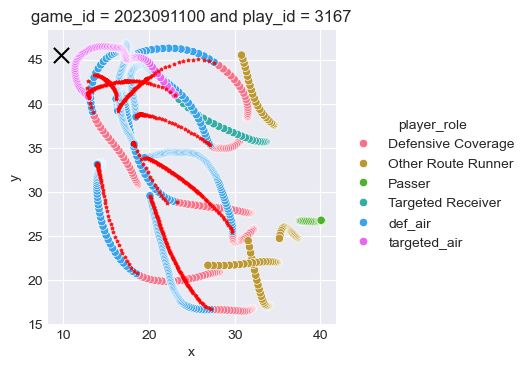

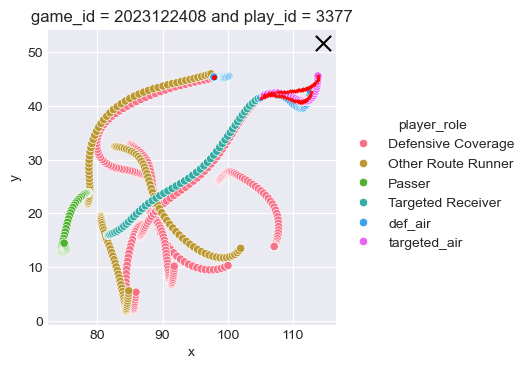

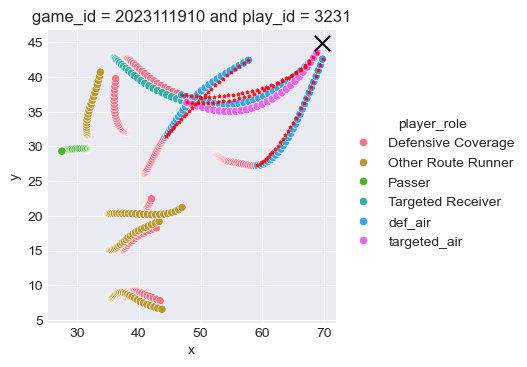

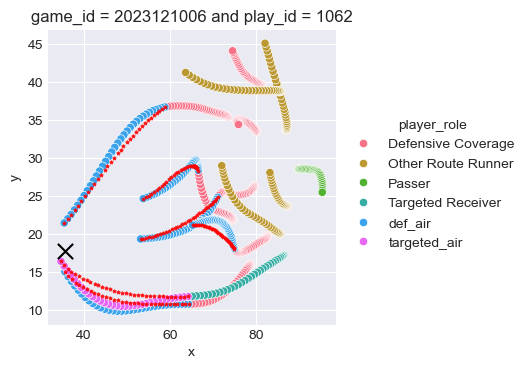

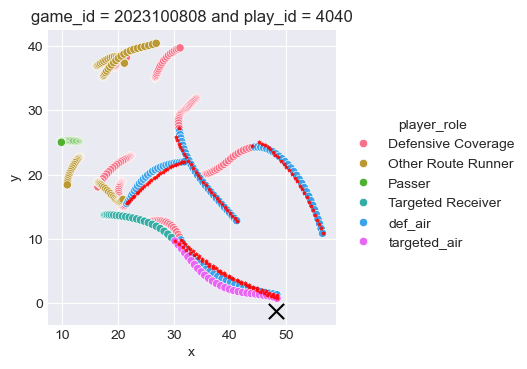

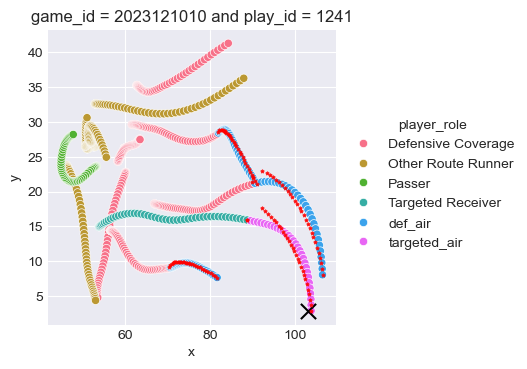

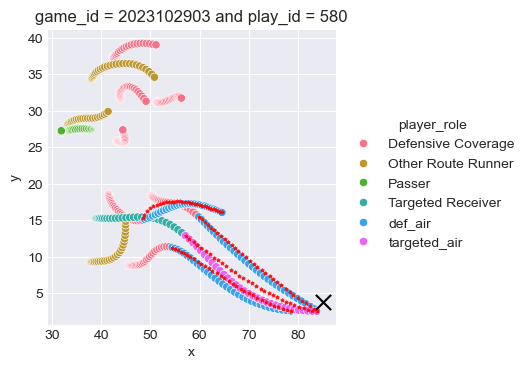

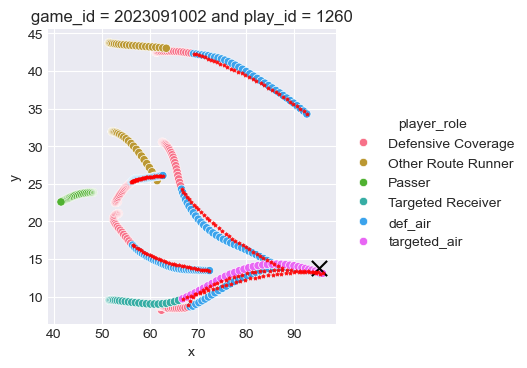

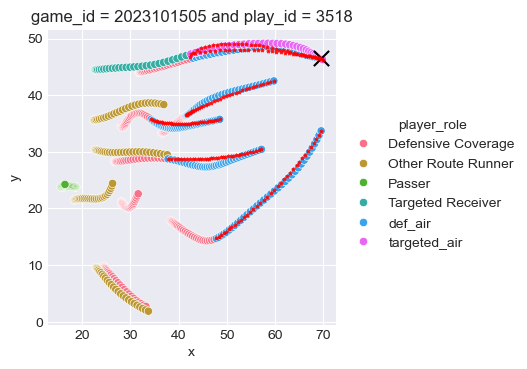

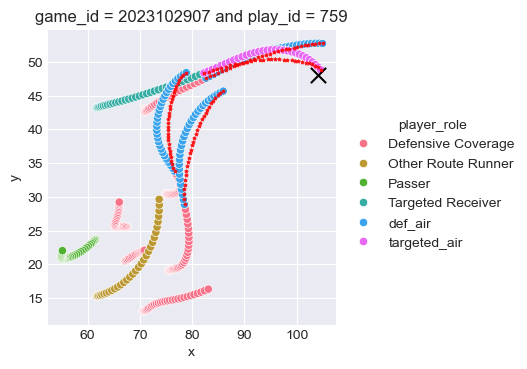

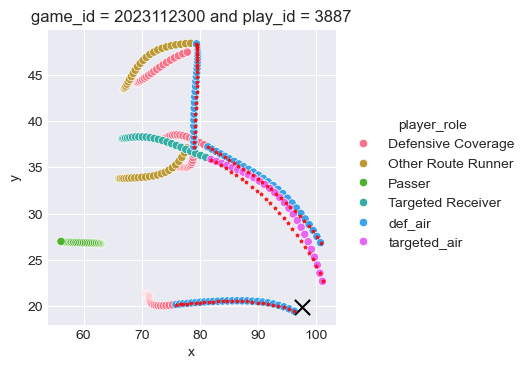

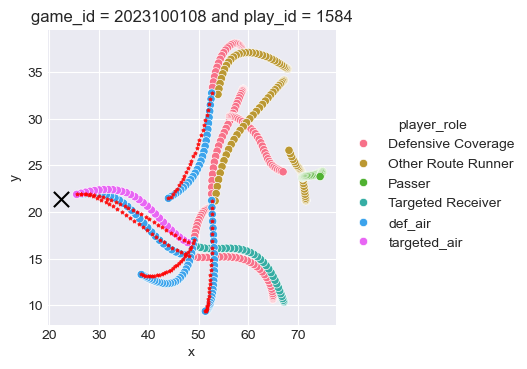

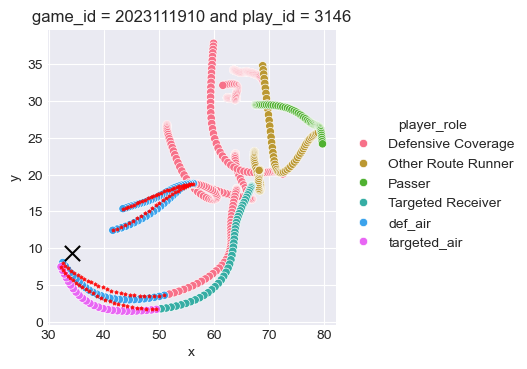

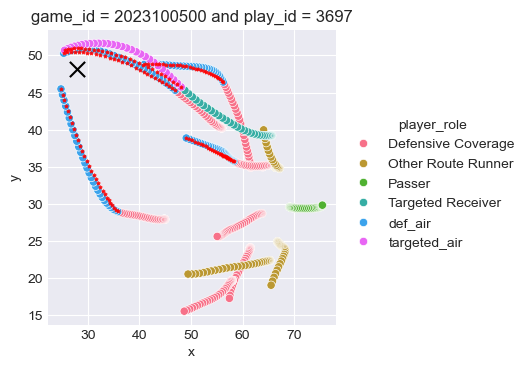

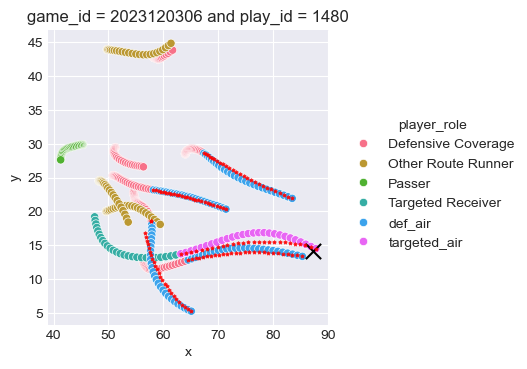

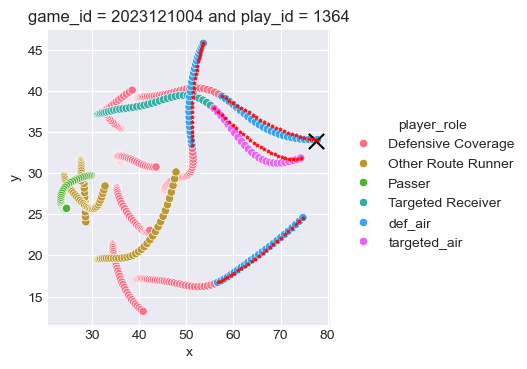

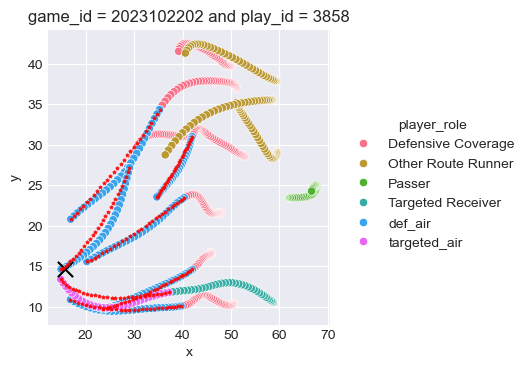

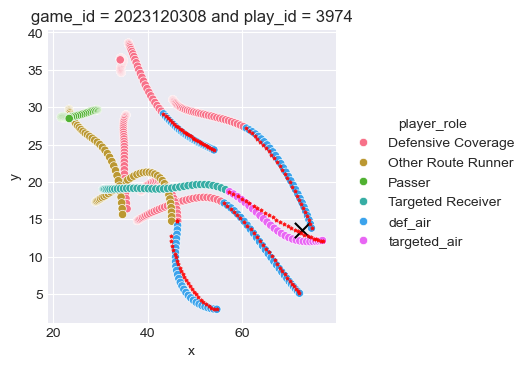

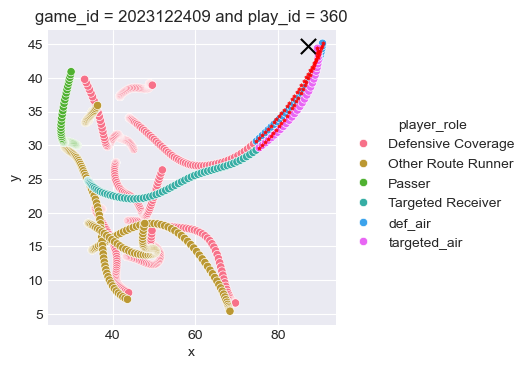

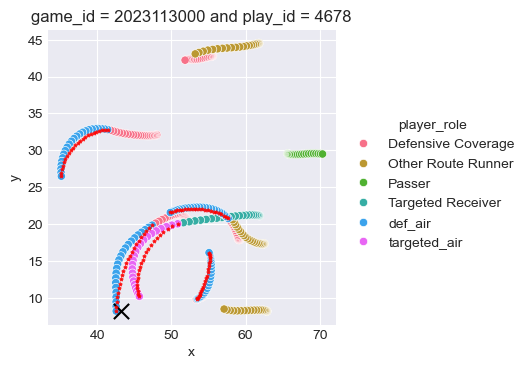

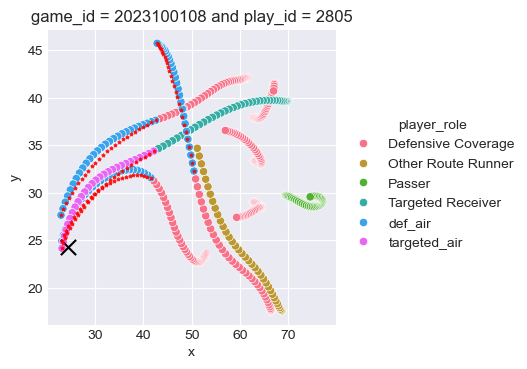

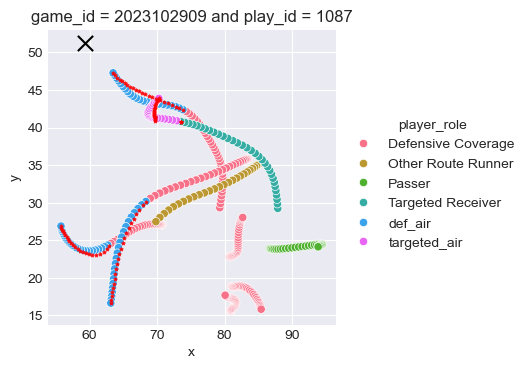

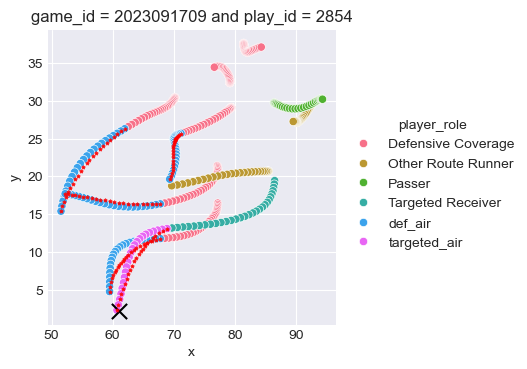

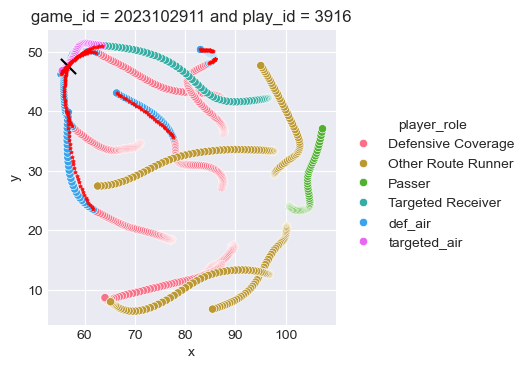

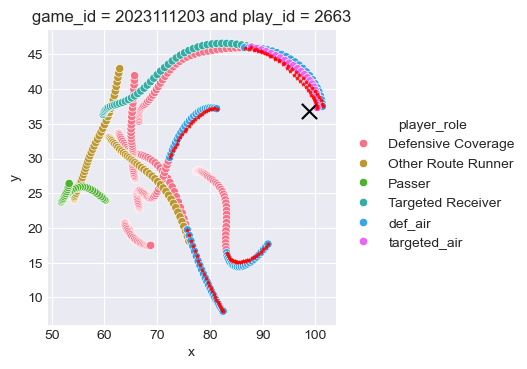

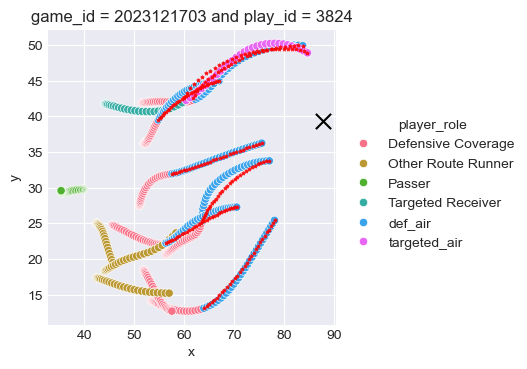

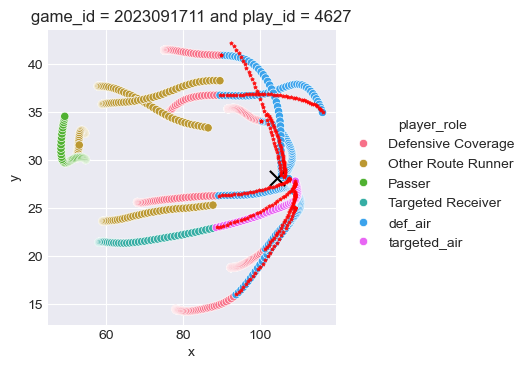

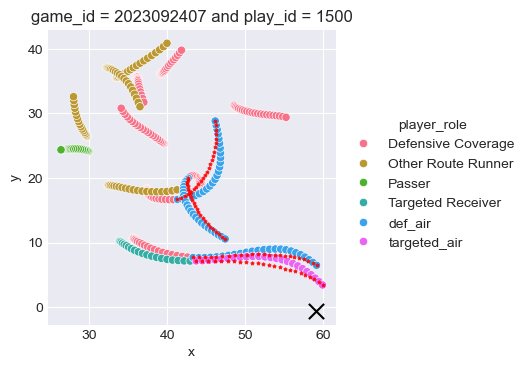

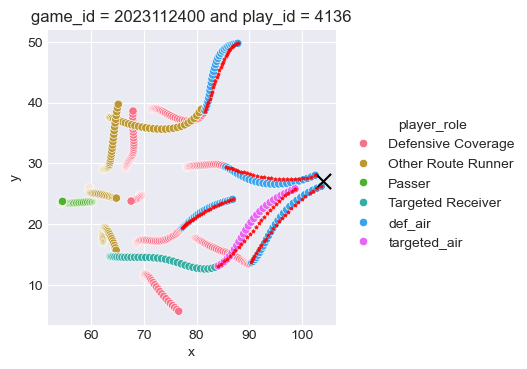

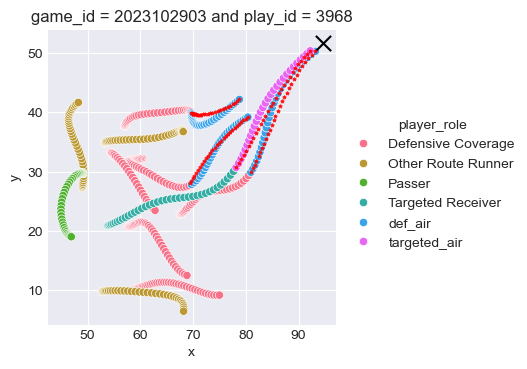

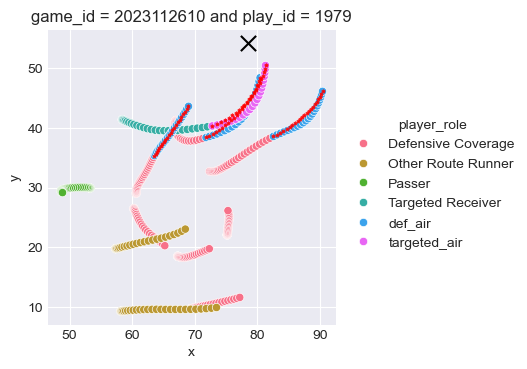

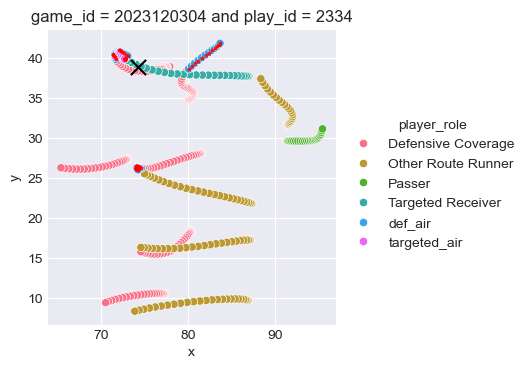

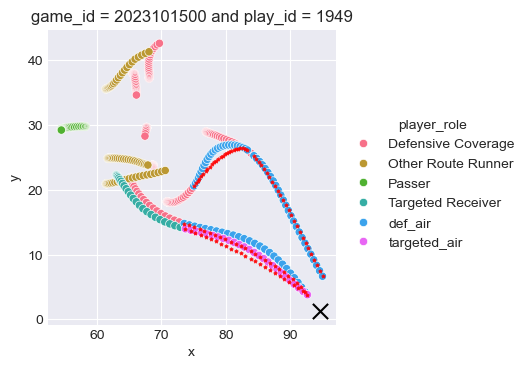

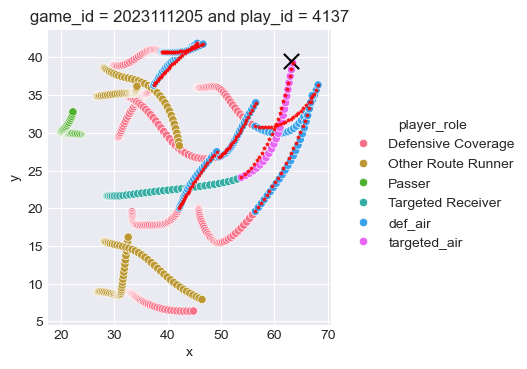

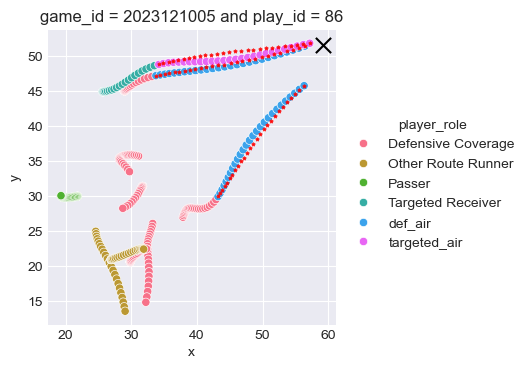

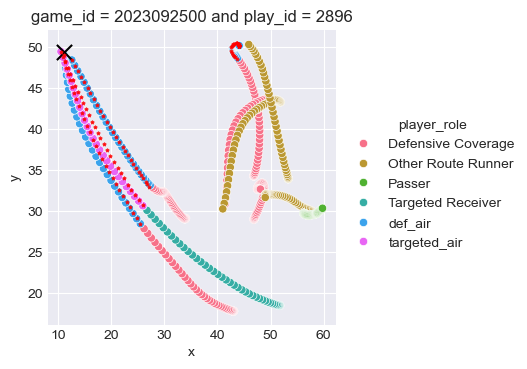

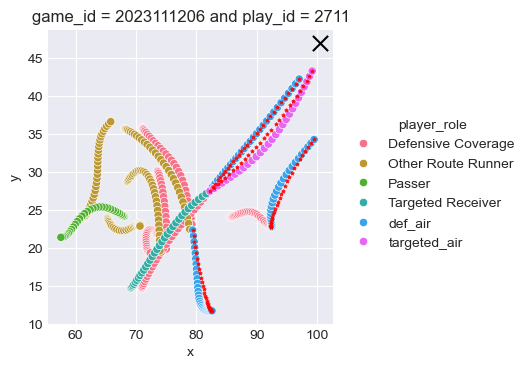

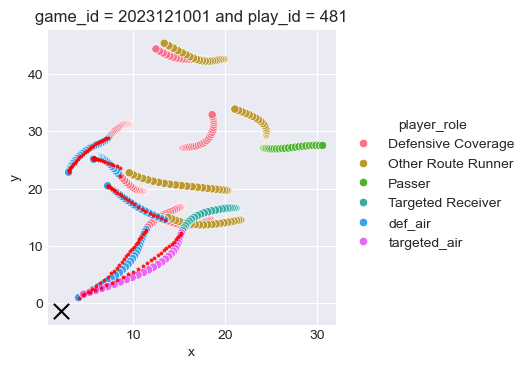

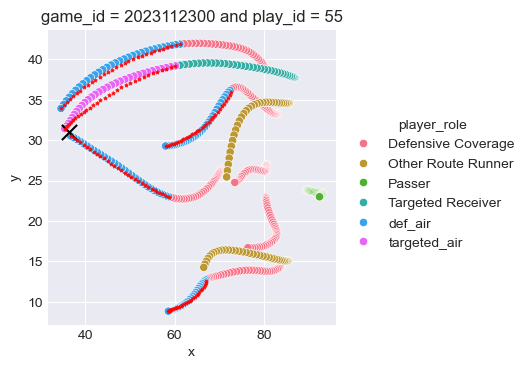

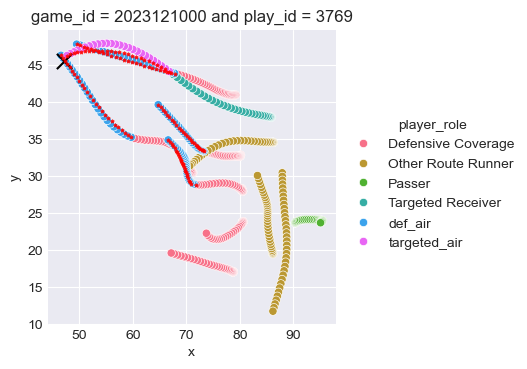

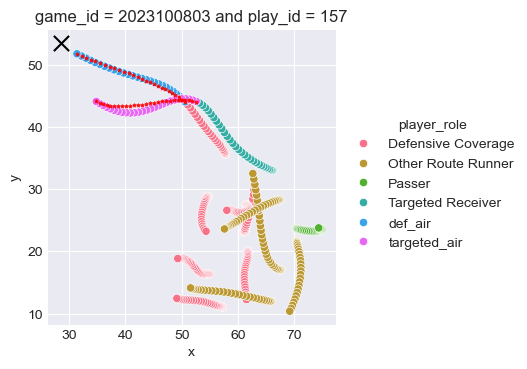

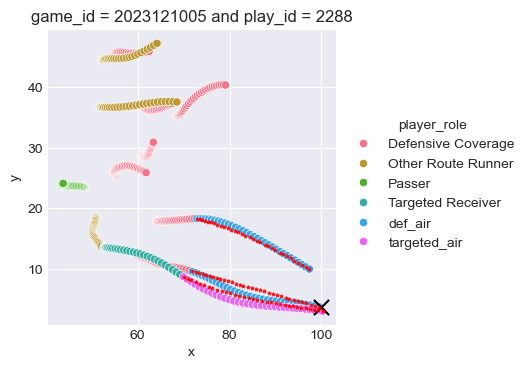

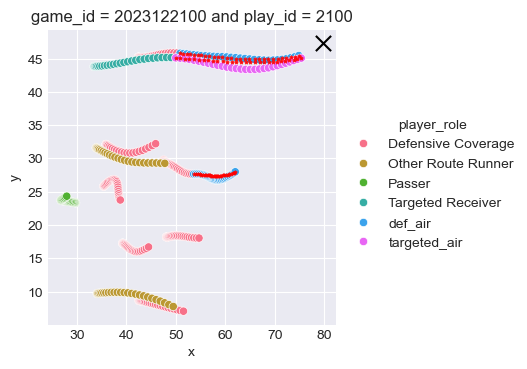

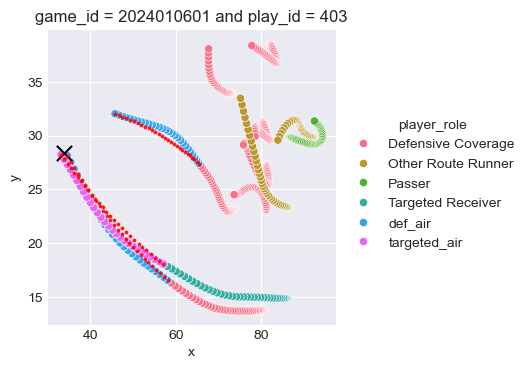

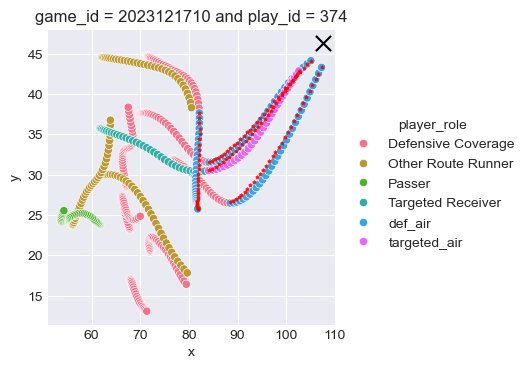

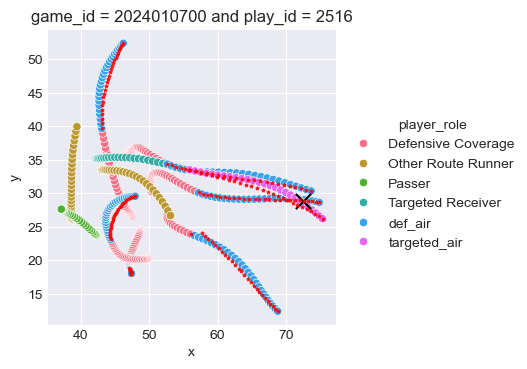

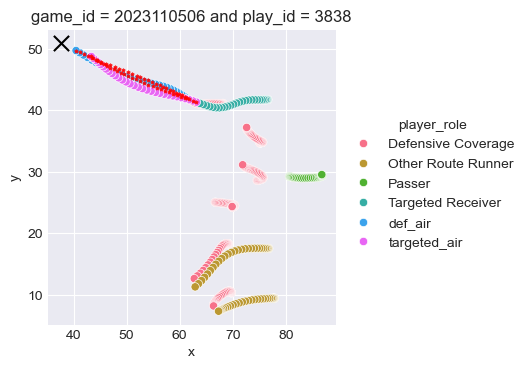

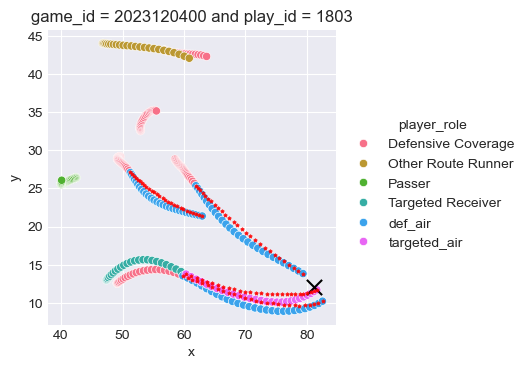

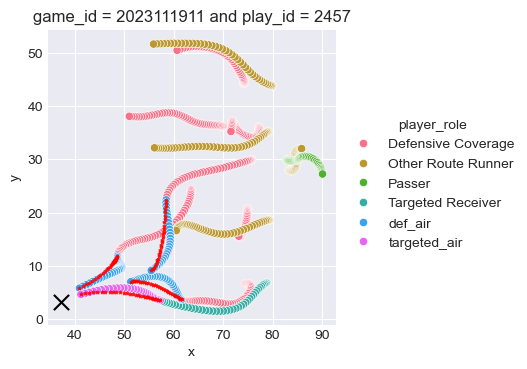

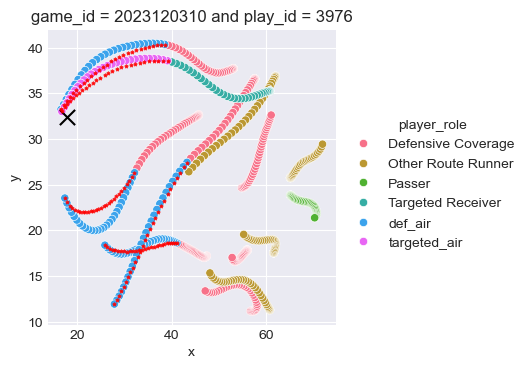

In [19]:
for _, r in worst_50.iterrows():
    game_id = int(r["game_id"])
    play_id = int(r["play_id"])

    merged_worst = efficient_routes.query(
        "game_id == @game_id and play_id == @play_id"
    )

    plot_play(game_id, play_id, merged_worst)
